In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import warnings
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import cross_val_score
import random

import kerastuner as kt


from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectPercentile
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()) # for Windows OS user
import datetime
import os

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from tensorflow import keras
from scipy.stats.mstats import gmean
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")
    

In [3]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(1)
    random.seed(2)
    tf.compat.v1.set_random_seed(3)
#    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


In [4]:
trn = pd.read_csv(os.path.abspath("../input")+'/X_train.csv', encoding='cp949')
tst = pd.read_csv(os.path.abspath("../input")+'/X_test.csv', encoding='cp949')
y = pd.read_csv(os.path.abspath("../input")+'/y_train.csv', encoding='cp949')
IDtest = tst.custid.unique()
data = pd.concat([trn, tst], axis=0)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1040039 entries, 0 to 414954
Data columns (total 19 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   custid           1040039 non-null  int64 
 1   sales_month      1040039 non-null  int64 
 2   sales_day        1040039 non-null  int64 
 3   sales_dayofweek  1040039 non-null  object
 4   sales_time       1040039 non-null  int64 
 5   str_nm           1040039 non-null  object
 6   goodcd           1040039 non-null  int64 
 7   brd_nm           1040039 non-null  object
 8   corner_nm        1040039 non-null  object
 9   pc_nm            1040039 non-null  object
 10  part_nm          1040039 non-null  object
 11  team_nm          1040039 non-null  object
 12  buyer_nm         1040039 non-null  object
 13  import_flg       1040039 non-null  int64 
 14  tot_amt          1040039 non-null  int64 
 15  dis_amt          1040039 non-null  int64 
 16  net_amt          1040039 non-null  in

#### mean_encoding

In [8]:
features_mean = []
newfeat = trn.merge(y, how='left')

In [11]:
f = newfeat[['custid','str_nm','age']].set_index('custid')
f= f.groupby('str_nm').agg('mean')
f = f.to_dict()['age']
data['str_nm_target'] = data.str_nm.apply(lambda x: f.get(x,0))
f = data.groupby('custid')['str_nm_target'].agg([('str_nm_tar_mean','mean')]).reset_index()
features_mean.append(f); f

In [27]:
f = newfeat[['custid','pc_nm','age']].set_index('custid')
f= f.groupby('pc_nm').agg('mean')
f = f.to_dict()['age']
data['pc_nm_target'] = data.pc_nm.apply(lambda x: f.get(x,0))
f = data.groupby('custid')['pc_nm_target'].agg([('pc_nm_tar_mean','mean')]).reset_index()
features_mean.append(f); f

,custid,pc_nm_tar_mean
0,0,36.444439
1,2,37.502349
2,3,37.968566
3,4,37.189765
4,5,38.718581
...,...,...
35962,49988,36.418850
35963,49990,35.994433
35964,49992,37.538058
35965,49993,37.722417


In [32]:
f = newfeat[['custid','part_nm','age']].set_index('custid')
f= f.groupby('part_nm').agg('mean')
f = f.to_dict()['age']
data['part_nm_target'] = data.part_nm.apply(lambda x: f.get(x,0))
f = data.groupby('custid')['part_nm_target'].agg([('part_nm_tar_mean','mean')]).reset_index()
features_mean.append(f); f

,custid,part_nm_tar_mean
0,0,37.824731
1,2,38.022331
2,3,37.952269
3,4,38.056806
4,5,39.415123
...,...,...
35962,49988,37.931375
35963,49990,36.931327
35964,49992,37.931375
35965,49993,36.870821


In [34]:
f = newfeat[['custid','buyer_nm','age']].set_index('custid')
f= f.groupby('buyer_nm').agg('mean')
f = f.to_dict()['age']
data['buyer_nm_target'] = data.buyer_nm.apply(lambda x: f.get(x,0))
f = data.groupby('custid')['buyer_nm_target'].agg([('buyer_nm_tar_mean','mean')]).reset_index()
features_mean.append(f); f

,custid,buyer_nm_tar_mean
0,0,36.575116
1,2,37.687634
2,3,38.078728
3,4,36.520959
4,5,38.202271
...,...,...
35962,49988,35.698535
35963,49990,35.893100
35964,49992,36.539181
35965,49993,37.999016


#### 날짜 데이터

In [44]:
data['sales_year']=data['sales_month'].apply(lambda x: 2018 if x >12 else 2017)

In [45]:
# 월 정리
data['sales_month']=data['sales_month'].apply(lambda x: x-12 if x >12 else x)

In [46]:
# 주말
data['weekend'] = data['sales_dayofweek'].apply(lambda x: 1 if (x=='토' or x=='일') else 0)

In [47]:
data['sales_year']=data['sales_year'].astype('str')
data['sales_month']=data['sales_month'].astype('str')
data['sales_day']=data['sales_day'].astype('str')

In [48]:
data['date_time']=data['sales_year']+'-'+data['sales_month']+'-'+data['sales_day']

In [49]:
data['sales_year']=data['sales_year'].astype('int')
data['sales_month']=data['sales_month'].astype('int')
data['sales_day']=data['sales_day'].astype('int')

In [50]:
data['date_time'] = pd.to_datetime(data['date_time'])

In [51]:
a=data.groupby(['custid'])['date_time'].diff()
a=a.reset_index().set_index(data.custid)
a=a.reset_index()
a.set_index('index',inplace=True)

In [55]:
data['date_time_diff']=a.date_time
dtdt=data.groupby(['custid','date_time'])['date_time_diff'].sum().reset_index()
dtdt.date_time_diff=dtdt.date_time_diff.astype('str')
dtdt.date_time_diff=dtdt.date_time_diff.apply(lambda x: x.split(' ')[0])
dtdt.date_time_diff=dtdt.date_time_diff.astype('int')
dtdt_mean=dtdt.groupby('custid')['date_time_diff'].mean().reset_index()

#### 쇼핑시간

In [61]:
ab=data.groupby(['custid','sales_day','sales_month'])['sales_time'].agg([('sales_time_min', 'min')]).reset_index()

In [62]:
abc=data.groupby(['custid','sales_day','sales_month'])['sales_time'].agg([('sales_time_max', 'max')]).reset_index()

In [63]:
# 시각의 자릿수가 두자리이면 문자 갯수가 4이기 때문에 다르게 인식하는 것
ab['time_min']=ab['sales_time_min'].apply(lambda x: int(str(x)[:2]) if len(str(x)) == 4 else int(str(x)[:1]))
ab['minute_min']=ab['sales_time_min'].apply(lambda x: int(str(x)[2:]) if len(str(x)) == 4 else int(str(x)[1:]))

In [64]:
ab['time_max']=abc['sales_time_max'].apply(lambda x: int(str(x)[:2]) if len(str(x)) == 4 else int(str(x)[:1]))
ab['minute_max']=abc['sales_time_max'].apply(lambda x: int(str(x)[2:]) if len(str(x)) == 4 else int(str(x)[1:]))

In [65]:
ab['shop_time']=(ab['time_max']-ab['time_min'])*60+(ab['minute_max']-ab['minute_min'])

In [66]:
shop_time=ab.groupby('custid')['shop_time'].mean().reset_index()

### word2vec

#### customer_info = brd_nm + corner_nm + pc_nm + part_nm

In [6]:
# 구매 정보 관련
trn['customer_info'] = trn['brd_nm'].astype(str) + '_' + trn['corner_nm'].astype(str) + '_' + trn['pc_nm'].astype(str) + '_' + trn['part_nm'].astype(str)

tst['customer_info'] = tst['brd_nm'].astype(str) + '_' + tst['corner_nm'].astype(str) + '_' + tst['pc_nm'].astype(str) + '_' + tst['part_nm'].astype(str)

In [7]:
trn['customer_info'].nunique()

6065

In [11]:
tst['customer_info'].nunique()

5546

In [12]:
import random

train_data = list(trn.groupby('custid')['customer_info'].unique())
test_data = list(tst.groupby('custid')['customer_info'].unique())

In [254]:
def oversample(x, n,seed=0):
    lst = []
    for i in x:
        tmp = []
        np.random.seed(seed)
        for j in range(n):
            random.shuffle(i)
            tmp += list(i)
            lst.append(tmp)
    return lst

In [255]:
w2v_input = oversample(train_data, 10)

In [256]:
from gensim.models import word2vec

w2v = word2vec.Word2Vec(sentences = w2v_input, size = 100, window = 5, min_count = 1, sg = 1,seed=0)

In [257]:
train_mean_vector = []
for words in tqdm(train_data):
    tmp = np.zeros(100)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector.append(tmp)
train_mean_vector = np.array(train_mean_vector)

100%|█████████████████████████████████████████████████████████████████████████| 21587/21587 [00:01<00:00, 11473.71it/s]


In [258]:
test_mean_vector = []
for words in tqdm(test_data):
    tmp = np.zeros(100)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector.append(tmp)
test_mean_vector = np.array(test_mean_vector)

100%|█████████████████████████████████████████████████████████████████████████| 14380/14380 [00:01<00:00, 11249.25it/s]


In [259]:
train_mean_vector = pd.DataFrame(train_mean_vector)
test_mean_vector = pd.DataFrame(test_mean_vector)

In [260]:
train_mean_vector.isnull().sum().sum(),test_mean_vector.isnull().sum().sum()

(0, 100)

In [261]:
test_mean_vector.fillna(0,inplace=True)

In [262]:
import pickle
## save
with open('train_mean_vector.pickle', 'wb') as f:
    pickle.dump(train_mean_vector, f, pickle.HIGHEST_PROTOCOL)

In [263]:
import pickle
## save
with open('test_mean_vector.pickle', 'wb') as f:
    pickle.dump(test_mean_vector, f, pickle.HIGHEST_PROTOCOL)

#### customer_info_time = str_nm + sales_dayofweek + season_sales+time_split

In [264]:
# 계절별 구매 빈도 추가
def f1(x):
    if 3 <= x <= 5 :
        return('spring_sales')
    elif 6 <= x <= 8 :
        return('summer_sales')
    elif 9 <= x <= 11 :
        return('fall_sales')
    else :
        return('winter_sales')    

In [265]:
data['season_sales']=data['sales_month'].apply(f1)

In [266]:
train=data[:625083]
test=data[625084:]

In [267]:
# 시간대 구분 (회사원 기준)
train['time_split'] = trn['sales_time'].apply(lambda x : 'MORNINGTIME' if (x>=700) and (x<=1130)
                                               else 'LUNCHTIME' if (x>1130) and (x<=1300)
                                               else 'AFTERNOON' if (x>1300) and (x<=1900)
                                               else 'RESTTIME')

test['time_split'] = tst['sales_time'].apply(lambda x : 'MORNINGTIME' if (x>=700) and (x<=1130)
                                               else 'LUNCHTIME' if (x>1130) and (x<=1300)
                                               else 'AFTERNOON' if (x>1300) and (x<=1900)
                                               else 'RESTTIME')

In [268]:
# 구매시간 정보
train['customer_info_time'] = train['sales_dayofweek'].astype(str) + '_' + train['season_sales'].astype(str) + '_' + train['time_split'].astype(str)

test['customer_info_time'] = test['sales_dayofweek'].astype(str) + '_' + test['season_sales'].astype(str) + '_' + test['time_split'].astype(str)

In [269]:
import random

train_data = list(train.groupby('custid')['customer_info_time'].unique())
test_data = list(test.groupby('custid')['customer_info_time'].unique())

In [270]:
w2v_input = oversample(train_data, 10)

In [271]:
from gensim.models import word2vec

w2v = word2vec.Word2Vec(sentences = w2v_input, size = 100, window = 5, min_count = 1, sg = 1)

In [272]:
train_mean_vector1 = []
for words in tqdm(train_data):
    tmp = np.zeros(100)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector1.append(tmp)
train_mean_vector1 = np.array(train_mean_vector1)

100%|█████████████████████████████████████████████████████████████████████████| 21587/21587 [00:01<00:00, 17880.17it/s]


In [273]:
test_mean_vector1 = []
for words in tqdm(test_data):
    tmp = np.zeros(100)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector1.append(tmp)
test_mean_vector1 = np.array(test_mean_vector1)

100%|█████████████████████████████████████████████████████████████████████████| 14380/14380 [00:00<00:00, 17790.12it/s]


In [274]:
train_mean_vector1 = pd.DataFrame(train_mean_vector1)
test_mean_vector1 = pd.DataFrame(test_mean_vector1)

In [275]:
import pickle
## save
with open('train_mean_vector1.pickle', 'wb') as f:
    pickle.dump(train_mean_vector1, f, pickle.HIGHEST_PROTOCOL)

In [276]:
import pickle
## save
with open('test_mean_vector1.pickle', 'wb') as f:
    pickle.dump(test_mean_vector1, f, pickle.HIGHEST_PROTOCOL)

#### goodcd

In [584]:
# income_occyp_type, income_age_type, edu_occyp_type, edu_income_type, family_income_type

import random

trn2=trn.reset_index().drop('index',axis=1).copy()
trn2=trn2.reset_index()
trn2['goodcd']=trn2['goodcd'].astype('str')
train_data=list(trn2.groupby('custid')['goodcd'].unique())

In [585]:
def oversample(x, n):
    lst = []
    for i in x:
        tmp = []
        for j in range(n):
            random.shuffle(i)
            tmp += list(i)
            lst.append(tmp)
    return lst

In [586]:
w2v_input = oversample(train_data, 5)

In [587]:
from gensim.models import word2vec
w2v = word2vec.Word2Vec(sentences = w2v_input, size = 100, window = 3, min_count = 1, sg = 1)

In [588]:
train_mean_vector = []
for words in tqdm(train_data):
    tmp = np.zeros(100)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector.append(tmp)
train_mean_vector = np.array(train_mean_vector)

100%|█████████████████████████████████████████████████████████████████████████| 21587/21587 [00:01<00:00, 12080.00it/s]


In [589]:
train_mean_vector = pd.DataFrame(train_mean_vector)
train_mean_vector

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.144323,-0.268593,0.197830,-0.034078,-0.010634,-0.072571,-0.155758,0.024709,-0.004502,-0.118695,...,-0.022690,0.124745,0.036699,0.056032,0.276451,0.269137,0.011492,0.152564,-0.098052,0.039434
1,-0.098021,-0.395419,0.152359,-0.030305,-0.231516,-0.116648,0.003360,-0.252212,0.022645,-0.102189,...,0.004354,0.056690,0.000893,0.154616,0.271934,0.196364,-0.260559,0.236958,-0.080918,0.284316
2,-0.077051,-0.259584,0.277543,0.152713,0.250707,0.074979,0.097563,-0.147708,0.061654,-0.120720,...,-0.073173,-0.001815,0.019788,0.132180,0.360719,0.214175,-0.097149,0.110110,-0.034951,0.074060
3,-0.018981,-0.279253,0.403917,0.218487,-0.159937,-0.061593,-0.060668,-0.040885,0.214933,-0.074717,...,0.225626,-0.050878,-0.088012,0.676289,0.240453,0.448307,-0.001719,-0.156652,0.359539,-0.122622
4,-0.006406,-0.147912,0.194968,-0.029545,0.029772,0.020132,-0.163050,-0.158720,-0.002155,-0.055020,...,0.015638,0.005054,0.095058,0.068094,0.216768,0.263295,-0.111932,-0.039474,-0.031801,0.107247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21582,-0.047208,-0.390859,0.099789,0.036606,0.005997,-0.249147,-0.232567,0.045683,0.069805,-0.080205,...,-0.100574,-0.001459,-0.077207,0.162558,0.392169,0.276467,-0.034129,0.087867,-0.050174,0.097632
21583,-0.208979,-0.302581,0.082338,-0.019715,-0.084864,0.059955,-0.124320,-0.031594,0.043823,0.018893,...,0.040590,0.017645,-0.195209,0.310201,0.265753,0.232559,-0.208179,0.013349,-0.010042,0.141635
21584,-0.027314,-0.186412,0.036101,-0.142100,-0.014941,-0.246432,-0.051719,0.035959,0.185666,-0.067376,...,0.019714,0.053179,-0.240394,0.152787,0.462484,0.291054,-0.170619,0.082360,0.050413,0.209269
21585,-0.125583,-0.143443,0.276443,0.187808,0.068731,0.002162,-0.131727,-0.101011,0.186247,-0.059716,...,0.105391,0.084607,-0.049633,0.354610,0.232825,0.260237,-0.256420,0.166660,-0.066059,0.146053


In [590]:
# income_occyp_type, income_age_type, edu_occyp_type, edu_income_type, family_income_type

import random

tst2=tst.reset_index().drop('index',axis=1).copy()
tst2=tst2.reset_index()
tst2['goodcd']=tst2['goodcd'].astype('str')
test_data=list(tst2.groupby('custid')['goodcd'].unique())

In [591]:
test_mean_vector = []
for words in tqdm(test_data):
    tmp = np.zeros(100)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector.append(tmp)
test_mean_vector = np.array(test_mean_vector)

100%|█████████████████████████████████████████████████████████████████████████| 14380/14380 [00:01<00:00, 11884.44it/s]


In [592]:
test_mean_vector = pd.DataFrame(test_mean_vector)
test_mean_vector

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.057559,-0.296036,0.114920,-0.076338,-0.164954,-0.168961,-0.260377,-0.166786,-0.047536,-0.068296,...,0.074330,0.016983,0.075861,0.028129,0.223909,0.196585,0.057957,0.157687,-0.186967,0.081998
1,-0.137682,-0.237492,0.163749,0.076731,0.130093,-0.093459,-0.191641,0.002772,0.130364,-0.098610,...,-0.077211,-0.040014,-0.005195,0.178763,0.308321,0.248290,-0.129177,0.074483,-0.113529,0.058980
2,-0.096139,-0.252574,0.245184,-0.031221,-0.059827,0.201953,-0.209133,-0.000823,0.178194,-0.064730,...,0.061576,-0.076105,-0.088217,0.242829,0.072702,0.099506,-0.145247,0.016494,0.138106,0.208594
3,-0.056233,-0.152458,0.087679,-0.047790,0.124579,0.045336,-0.156751,0.044902,0.053946,-0.111123,...,0.024557,-0.085635,-0.213758,0.116544,0.173242,0.149649,-0.306621,0.086035,0.073079,0.100721
4,-0.171590,-0.276474,0.015301,0.053183,0.171842,0.101730,-0.173377,-0.062586,0.031539,-0.111422,...,0.081755,-0.114964,-0.247074,0.248575,0.104175,0.293454,-0.267686,0.198240,-0.109773,-0.001764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14375,-0.168402,-0.311017,0.000747,-0.137941,0.118846,-0.234939,-0.325825,-0.137096,0.150449,-0.020354,...,0.052506,-0.240179,0.075712,0.027874,0.344606,0.200713,-0.157998,0.174613,-0.108493,0.120855
14376,-0.034267,-0.230976,0.106911,-0.203869,0.153405,0.116296,-0.047896,-0.111250,0.037653,-0.139375,...,-0.081653,0.095861,-0.145100,0.101180,0.128748,0.199945,-0.150141,0.143817,-0.106212,-0.008779
14377,-0.170406,-0.292972,-0.077190,-0.182222,-0.035382,-0.327804,-0.149496,0.053931,-0.133849,0.010821,...,-0.054716,0.118709,0.154340,0.186622,0.339342,0.393350,0.004752,-0.031219,0.061336,0.102499
14378,-0.080319,-0.147048,-0.038252,0.064179,0.098606,0.259903,-0.116665,-0.252119,-0.041359,-0.045233,...,0.020405,-0.284774,-0.007716,-0.099579,0.046672,0.149953,-0.082328,0.034290,0.053548,-0.000764


In [593]:
import pickle
## save
with open('train_mean_vector_good.pickle', 'wb') as f:
    pickle.dump(train_mean_vector, f, pickle.HIGHEST_PROTOCOL)

In [594]:
import pickle
## save
with open('test_mean_vector_good.pickle', 'wb') as f:
    pickle.dump(test_mean_vector, f, pickle.HIGHEST_PROTOCOL)

#### brd_nm

In [97]:
# income_occyp_type, income_age_type, edu_occyp_type, edu_income_type, family_income_type

import random

trn2=trn.reset_index().drop('index',axis=1).copy()
trn2=trn2.reset_index()
train_data=list(trn2.groupby('custid')['brd_nm'].unique())

In [98]:
def oversample(x, n):
    lst = []
    for i in x:
        tmp = []
        for j in range(n):
            random.shuffle(i)
            tmp += list(i)
            lst.append(tmp)
    return lst

In [99]:
w2v_input = oversample(train_data, 5)

In [100]:
from gensim.models import word2vec

w2v = word2vec.Word2Vec(sentences = w2v_input, size = 100, window = 3, min_count = 1, sg = 1)

In [101]:
train_mean_vector_2 = []
for words in tqdm(train_data):
    tmp = np.zeros(100)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector_2.append(tmp)
train_mean_vector_2 = np.array(train_mean_vector_2)

100%|█████████████████████████████████████████████████████████████████████████| 21587/21587 [00:01<00:00, 13817.00it/s]


In [102]:
train_mean_vector_2 = pd.DataFrame(train_mean_vector_2)
train_mean_vector_2

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.099359,0.229848,0.001726,0.065618,-0.077882,0.141544,0.029603,0.131862,-0.104955,-0.206811,...,-0.121027,0.149032,-0.143528,0.000074,0.258949,-0.123598,-0.112917,0.118791,0.072575,-0.258159
1,-0.148271,0.168280,0.074423,-0.116408,-0.074596,0.164001,0.001238,0.089994,-0.035212,-0.181781,...,-0.045649,0.178929,-0.097523,0.062516,0.158933,-0.129134,-0.052119,0.039353,0.006741,-0.270934
2,-0.209073,0.164122,-0.088313,0.026671,-0.099755,0.126713,0.088443,0.121720,-0.157667,-0.372412,...,-0.067356,0.068995,-0.021621,0.138720,0.058073,-0.133802,-0.155317,-0.030555,-0.070853,-0.257945
3,-0.177481,0.377796,0.160337,-0.150246,-0.175173,0.289743,0.090508,0.314686,-0.299155,-0.010455,...,-0.216118,0.011734,-0.159354,0.198609,0.043519,-0.381176,-0.071579,-0.004116,0.108335,0.077561
4,-0.188473,0.112612,0.000741,-0.003990,-0.086077,0.120941,0.107368,0.057337,-0.076843,-0.222488,...,-0.045428,0.140131,-0.083319,-0.001670,0.101014,-0.217243,-0.080381,0.106238,0.016119,-0.262751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21582,-0.142881,0.171760,0.051145,0.146917,-0.034540,0.155963,0.084235,0.122642,-0.115169,-0.203340,...,-0.066174,0.070993,-0.140773,0.089975,0.085778,-0.251992,-0.010128,0.120774,0.070248,-0.075598
21583,-0.052365,0.209897,0.085776,0.031980,-0.136825,0.168982,0.046745,0.182240,-0.073883,-0.236916,...,-0.166680,0.041617,-0.164772,0.159023,0.058920,-0.195668,-0.061867,0.070360,0.059676,-0.190173
21584,-0.120541,0.102348,-0.034221,0.135927,0.011785,0.133389,0.116404,0.198307,-0.095573,-0.320705,...,0.016061,-0.077538,-0.058656,-0.047204,0.146772,-0.225361,-0.024000,0.091415,0.055977,-0.124696
21585,-0.088767,0.183101,0.121097,0.041343,-0.066061,0.097650,0.103824,0.184291,-0.164192,-0.194438,...,-0.176102,0.089446,-0.190146,0.144457,0.041963,-0.107956,-0.100026,0.111624,-0.057649,-0.143844


In [103]:
# income_occyp_type, income_age_type, edu_occyp_type, edu_income_type, family_income_type

import random

tst2=tst.reset_index().drop('index',axis=1).copy()
tst2=tst2.reset_index()
test_data=list(tst2.groupby('custid')['brd_nm'].unique())

In [104]:
test_mean_vector_2 = []
for words in tqdm(test_data):
    tmp = np.zeros(100)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector_2.append(tmp)
test_mean_vector_2 = np.array(test_mean_vector_2)

100%|█████████████████████████████████████████████████████████████████████████| 14380/14380 [00:01<00:00, 13770.61it/s]


In [105]:
test_mean_vector_2 = pd.DataFrame(test_mean_vector_2)
test_mean_vector_2

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.122656,0.216789,0.054525,0.051357,-0.081809,0.134494,0.030452,0.119468,-0.065105,-0.209350,...,-0.092898,0.143492,-0.094360,0.027026,0.225925,-0.144084,-0.030519,0.088379,0.003156,-0.213106
1,-0.120233,0.143215,0.045958,0.051132,-0.011490,0.125507,0.034136,0.093216,-0.063237,-0.268051,...,-0.097375,0.058727,-0.098590,0.067234,0.089169,-0.188219,-0.049308,0.093123,0.033251,-0.252178
2,-0.196941,0.130768,0.053954,0.090406,-0.053738,0.114268,0.104093,0.104881,-0.120869,-0.174747,...,-0.156218,0.078043,-0.105169,0.107210,0.027203,-0.090784,0.010746,0.083774,0.067833,-0.178055
3,-0.062131,0.324611,0.121338,0.211037,-0.214838,-0.007224,0.126483,0.165214,0.000144,-0.138296,...,-0.283600,-0.017036,-0.234514,0.071472,0.063863,-0.240795,0.019607,0.156207,0.209697,-0.177349
4,-0.214753,0.248412,0.120212,-0.007139,-0.107194,0.100556,0.076524,0.146680,-0.092050,-0.069768,...,-0.138405,0.007433,-0.053476,0.130685,0.045783,-0.154345,-0.162498,0.099175,0.071110,-0.236209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14375,-0.146219,0.044447,-0.010113,0.088289,-0.059829,0.152261,0.195043,0.287960,-0.014177,-0.129112,...,0.114445,0.155443,-0.003605,0.070704,-0.047171,-0.185280,-0.013389,0.139391,0.010890,-0.384596
14376,-0.159082,0.255758,0.077017,-0.064341,-0.093868,0.134684,0.076568,0.207802,-0.158940,-0.001104,...,-0.094023,0.005866,-0.070563,0.125681,0.181137,-0.034188,-0.014389,0.055022,0.062635,-0.344001
14377,-0.145854,0.114265,-0.133513,-0.080089,-0.116625,0.173706,0.127648,0.211195,-0.023584,-0.354340,...,-0.024941,0.019279,-0.029240,0.085955,0.311522,-0.232197,-0.133312,0.107663,0.009735,-0.208561
14378,-0.109856,0.179297,-0.011043,-0.115616,-0.118027,0.107160,-0.039540,0.186736,-0.053808,-0.265585,...,-0.069942,0.077971,0.024693,0.070882,-0.030771,0.050907,-0.036859,0.067216,-0.040569,-0.325106


In [106]:
import pickle
## save
with open('train_mean_vector_brd.pickle', 'wb') as f:
    pickle.dump(train_mean_vector_2, f, pickle.HIGHEST_PROTOCOL)

In [107]:
import pickle
## save
with open('test_mean_vector_brd.pickle', 'wb') as f:
    pickle.dump(test_mean_vector_2, f, pickle.HIGHEST_PROTOCOL)

#### feature

sales time - 아침/ 낮/ 밤 구매 나누기

In [116]:
data['sales_time'] = data['sales_time'].apply(lambda x: int(str(x)[:2]) if len(str(x)) == 4 else int(str(x)[:1]))
data['sales_time_cat'] = data['sales_time'].apply(lambda x: 'mo_sales' if (9 <= x <= 12) else ('af_sales' if (13 <= x <= 18) else 'knt_sales'))

dis_amt - 할인율 특성 추가

In [117]:
data['dis_rate'] = data['dis_amt']/data['tot_amt']

퇴근전/후 구매 빈도, 비율

In [118]:
def get_off_work(x):
    if 9<=x<=17:
        return('bf_work')
    else:
        return('af_work')

In [119]:
data['sales_type'] = data['sales_time'].map(get_off_work)

시간별 구매 횟수

In [120]:
freq_per_time = pd.pivot_table(index='custid',columns='sales_time',values='tot_amt',aggfunc=np.size, fill_value=0, data=data.query("tot_amt>0")[['custid','sales_time','tot_amt']]).reset_index()

In [121]:
sales_type = pd.pivot_table(index='custid',columns='sales_type',values='tot_amt',aggfunc=np.size, fill_value=0,data = data.query('tot_amt>0')[['custid','sales_type','tot_amt']]).reset_index()

In [122]:
freq_per_time.columns=['custid', '1_stf', '9_stf', "10_stf", '11_stf', '12_stf', '13_stf', '14_stf', '15_stf', '16_stf', '17_stf', '18_stf', '19_stf', '20_stf', '21_stf', '22_stf']

In [123]:
features = pd.merge(freq_per_time, sales_type, on = 'custid')
features = pd.merge(features, shop_time, on = 'custid')
features = pd.merge(features, dtdt_mean, on = 'custid')

점포별 가중치

In [126]:
def floor_transfer_a(x) :
    return  {
        "무역점" : 0,
        "본점" : 1,
        "신촌점" : 0,
        "천호점" : 1
    }.get(x)

def floor_transfer_m(x) :  
    return  {
        "무역점" : 1/10*13,
        "본점" : 1/6*13,
        "신촌점" : 1/11*13,
        "천호점" : 1
    }.get(x)
data['floor'] = (data.str_nm.apply(floor_transfer_a))*data.str_nm.apply(floor_transfer_m).astype(int)

In [127]:
features = pd.merge(features, data.groupby('custid')['floor'].mean().reset_index(), on = 'custid')

아침구매/ 낮구매/ 밤구매

In [128]:
features['af_work_rate'] = features['af_work']/(features['af_work'] + features['bf_work'])
features['bf_work_rate'] = features['bf_work']/(features['af_work'] + features['bf_work'])

In [129]:
freq_sales_cat = pd.pivot_table(index='custid',columns='sales_time_cat',values='tot_amt',aggfunc=np.size, fill_value=0, data=data.query("tot_amt>0")[['custid','sales_time_cat','tot_amt']]).reset_index()
features = pd.merge(features, freq_sales_cat,on='custid')

환불

In [130]:
refund_freq=data.query('tot_amt<0').groupby('custid')['sales_day'].count().reset_index()
features = pd.merge(features, refund_freq, left_on = 'custid',right_on='custid',how='left')
features.rename(columns = {'sales_day': 'refund_freq'},inplace=True)
features.fillna(0,inplace=True)

In [131]:
sales_freq=data.query('tot_amt>0').groupby('custid')['sales_day'].count().reset_index()
features = pd.merge(features, sales_freq, left_on = 'custid',right_on='custid',how='left')
features.rename(columns = {'sales_day': 'sales_freq'},inplace=True)

구매 빈도 특성 추가

In [132]:
all_freq=data.groupby('custid')['sales_day'].count().reset_index()
features = pd.merge(features, all_freq,  left_on = 'custid',right_on='custid',how='left')
features.rename(columns = {'sales_day': 'all_freq'},inplace=True)

In [133]:
features['refund_sales_rate']=features['refund_freq']/features['sales_freq']
features['refund_all_rate'] = features['refund_freq']/features['all_freq']

방문한 날짜의 갯수

In [134]:
data_aaa=data.groupby(['custid','sales_month','sales_day'])['sales_dayofweek'].count().reset_index()
data_aaa.sales_dayofweek=1
data_aaa=data_aaa.groupby('custid')['sales_dayofweek'].sum().reset_index()

In [137]:
features = pd.merge(features, data_aaa, on = 'custid')

features['sales_freq_mean']=features['sales_freq']/features['sales_dayofweek']

평일에 방문하는 평균 시간

In [142]:
vuddlf=data[data.weekend==0].groupby('custid')['sales_time'].mean().reset_index()
features = pd.merge(features, vuddlf, how='left',on = 'custid')

wkdtjdgus=data[data.weekend==0].groupby('custid')['sales_time'].agg([('sales_time_mod', lambda x: x.mode().index[0])]).reset_index()
features = pd.merge(features, wkdtjdgus, how='left',on = 'custid')

주말에 방문하는 평균 시간

In [143]:
wnakf=data[data.weekend==1].groupby('custid')['sales_time'].mean().reset_index()
features = pd.merge(features, wnakf, how='left',on = 'custid')

wkdtjdgus=data[data.weekend==1].groupby('custid')['sales_time'].agg([('sales_time_mod', lambda x: x.mode().index[0])]).reset_index()
features = pd.merge(features, wkdtjdgus, how='left',on = 'custid')

In [147]:
# 수입상품 관련 열
sales_import=data.groupby('custid')['import_flg'].agg('sum').reset_index()
features = pd.merge(features, sales_import, on = 'custid')

features.rename(columns = {'import_flg': 'sales_import'},inplace=True)

In [148]:
# 수입상품 구매 빈도 추가
features['import_rate']=features['sales_import']/features['sales_freq']

In [149]:
# 수입상품 환불 빈도 추가
features['import_refund_rate']=features['sales_import']/(features['refund_freq']+1)

In [150]:
# 계절별 구매 빈도 추가
def f1(x):
    if 3 <= x <= 5 :
        return('spring_sales')
    elif 6 <= x <= 8 :
        return('summer_sales')
    elif 9 <= x <= 11 :
        return('fall_sales')
    else :
        return('winter_sales')    

In [151]:
data['season_sales']=data['sales_month'].apply(f1)

In [66]:
season = pd.pivot_table(data, index='custid', columns='season_sales', values='tot_amt', 
                   aggfunc=np.size, fill_value=0).reset_index()
features = pd.merge(features, season, how='left',on = 'custid')

In [67]:
#계절별 구매만 빈도
season_sales_freq = pd.pivot_table(index='custid',columns='season_sales',values='tot_amt',aggfunc=np.size, fill_value=0, data=data.query("tot_amt>0")[['custid','season_sales','tot_amt']]).reset_index()
features = pd.merge(features, season_sales_freq, how='left',on = 'custid')

In [68]:
#계절별 환불만 빈도
season_refund_freq = pd.pivot_table(index='custid',columns='season_sales',values='tot_amt',aggfunc=np.size, fill_value=0, data=data.query("tot_amt<0")[['custid','season_sales','tot_amt']]).reset_index()
features = pd.merge(features, season_refund_freq, how='left',on = 'custid')
features.fillna(0,inplace=True)

In [69]:
features['sales_fall_rate']=features.fall_sales_x/(features.fall_sales_x+features.spring_sales_x+features.summer_sales_x+features.winter_sales_x)
features['sales_spring_rate']=features.spring_sales_x/(features.fall_sales_x+features.spring_sales_x+features.summer_sales_x+features.winter_sales_x)
features['sales_summer_rate']=features.summer_sales_x/(features.fall_sales_x+features.spring_sales_x+features.summer_sales_x+features.winter_sales_x)
features['sales_winter_rate']=features.winter_sales_x/(features.fall_sales_x+features.spring_sales_x+features.summer_sales_x+features.winter_sales_x)

features['refund_fall_rate']=features.fall_sales_y/(features.fall_sales_y+features.spring_sales_y+features.summer_sales_y+features.winter_sales_y)
features['refund_spring_rate']=features.spring_sales_y/(features.fall_sales_y+features.spring_sales_y+features.summer_sales_y+features.winter_sales_y)
features['refund_summer_rate']=features.summer_sales_y/(features.fall_sales_y+features.spring_sales_y+features.summer_sales_y+features.winter_sales_y)
features['refund_winter_rate']=features.winter_sales_y/(features.fall_sales_y+features.spring_sales_y+features.summer_sales_y+features.winter_sales_y)

features['all_fall_rate']=features.fall_sales/(features.fall_sales+features.spring_sales+features.summer_sales+features.winter_sales)
features['all_spring_rate']=features.spring_sales/(features.fall_sales+features.spring_sales+features.summer_sales+features.winter_sales)
features['all_summer_rate']=features.summer_sales/(features.fall_sales+features.spring_sales+features.summer_sales+features.winter_sales)
features['all_winter_rate']=features.winter_sales/(features.fall_sales+features.spring_sales+features.summer_sales+features.winter_sales)

In [82]:
# 주말 구매 비율
features['wd_sales_rate'] = (data.groupby('custid')['weekend'].sum().reset_index()['weekend']/features['sales_freq'])*100

월별 구매액의 합, 평균

In [83]:
month_sales_mn=data.groupby(['custid','sales_month'])['net_amt'].mean().unstack().fillna(0)

month_sales_mn.columns = ['mon_sale_mn'+ str(column) for column in month_sales_mn.columns]
month_sales_mn = month_sales_mn.reset_index()

In [85]:
month_sales_sm=data.groupby(['custid','sales_month'])['net_amt'].sum().unstack().fillna(0)

month_sales_sm.columns = ['mon_sale_sm'+ str(column) for column in month_sales_sm.columns]
month_sales_sm = month_sales_sm.reset_index()

In [87]:
features = pd.merge(features, month_sales_sm, how='left',on = 'custid')

features = pd.merge(features, month_sales_mn, how='left',on = 'custid')

In [89]:
# 구매 월 평균
features['month_mean'] = data.groupby('custid')['sales_month'].mean().reset_index()['sales_month']

In [90]:
# 자주 가는 월 - 원래 자주가는 
#f = pd.pivot_table(data, index='custid', columns='sales_month', values='tot_amt', 
#                   aggfunc=np.size, fill_value=0).reset_index()
f=pd.pivot_table(data[data.tot_amt>0], index='custid', columns='sales_month', values='tot_amt', 
                   aggfunc=np.size, fill_value=0).reset_index()

In [91]:
f.columns=['custid', '1_mmff', '2_mmff', '3_mmff', '4_mmff', '5_mmff', '6_mmff', '7_mmff', '8_mmff', '9_mmff', '10_mmff', '11_mmff', '12_mmff']
features = pd.merge(features, f, how='left',on = 'custid')

금액 관리

In [93]:
refund_net_sum=data[data.net_amt<0].groupby('custid')['net_amt'].sum().reset_index()
features = pd.merge(features, refund_net_sum, how='left',on = 'custid')

In [94]:
net_saels_all=data.groupby('custid')['net_amt'].agg([('tot_sales_all','sum'),('mean_amt_all','mean')])
features = pd.merge(features, net_saels_all, how='left',on = 'custid').fillna(0)

In [95]:
net_sales_0_all=data[data.net_amt>0].groupby('custid')['net_amt'].agg([('tot_sales','sum'),('max_sales_amt','max'),('min_sales_amt','min'),('mean_sales_amt','mean')])
features = pd.merge(features, net_sales_0_all, how='left',on = 'custid').fillna(0)

In [96]:
net_refund_all=data[data.net_amt<0].groupby('custid')['net_amt'].agg([('tot_refund','sum'),('max_refund_amt','max'),('min_refund_amt','min'),('mean_refund_amt','mean')])
features = pd.merge(features, net_refund_all, how='left',on = 'custid').fillna(0)

In [97]:
features[['mean_amt_all','mean_sales_amt','mean_refund_amt']] =round(features[['mean_amt_all','mean_sales_amt','mean_refund_amt']],2)

features['tot_sales_freq_mean']=features['tot_sales']/features['sales_dayofweek']

In [99]:
# 총 할인금액
features['tot_dis_amt'] = data.groupby('custid')['dis_amt'].sum().reset_index()['dis_amt']

In [100]:
# 최대, 평균 할인율
features['max_dis'] = data.groupby('custid')['dis_rate'].max().reset_index()['dis_rate']
features['mean_dis'] = data.groupby('custid')['dis_rate'].mean().reset_index()['dis_rate']

In [101]:
# 할인 받은 빈도, 비율
dis_rate=data.query("dis_rate>0").groupby('custid')['dis_rate'].count().reset_index()
features = pd.merge(features, dis_rate, how='left',on='custid').fillna(0)
features.rename(columns = {'dis_rate': 'dis_freq'},inplace=True)

In [102]:
features['dis_freq_rate'] = features['dis_freq']/features['sales_freq']

In [103]:
# 할부 빈도, 비율/ 평균 할부개월
inst_ft = data.query("inst_mon != 1").groupby('custid')['inst_mon'].agg([('inst_freq','count'),('inst_avg','mean'),('inst_max','max')])
features = pd.merge(features, inst_ft, how='left',on = 'custid').fillna(0)
features['inst_freq_rate'] = features['inst_freq']/features['sales_freq']
features['inst_freq_all_rate'] = features['inst_freq']/features['all_freq']

In [104]:
# 할부 총 달
inst_ft_sum = data.groupby('custid')['inst_mon'].agg([('inst_sum','sum')])
features = pd.merge(features, inst_ft_sum, how='left',on = 'custid').fillna(0)

In [105]:
features['tot_inst_amt']=features['tot_sales']/features['inst_sum']

In [106]:
# 할부 총 달
sales_noinst = data.groupby('custid')['inst_fee'].agg([('inst_fee_sum','sum')])
features = pd.merge(features, sales_noinst, how='left',on = 'custid').fillna(0)

In [395]:
#def inst_avg(x):
#    if x >=3:
#        return 1
#    else:
#        return 0
#
#features['inst_quan'] = features.inst_avg.apply(inst_avg)

In [107]:
# 자주가는 지점이 어딘지 원핫인코딩 한 것
data['str_nm'] = data['str_nm'].apply(lambda x: 'mu' if x=='무역점' else('bon' if x=='본점' else('cheon' if x=='천호점' else 'sin')))

In [108]:
f = data.groupby(['custid','str_nm'])['str_nm'].agg([('str_freq','count')]).reset_index()

In [109]:
lst = []
for i in tqdm_notebook(f['custid'].unique()) : 
    f2 = f.query("custid == @i")
    lst.append(f2.sort_values(by='str_freq',ascending=False)['str_nm'].iloc[0])

features['str_freq'] = lst

In [110]:
features = pd.get_dummies(features, 'str_freq')

아이디 별 매장별 몇번씩 갔는지

In [111]:
str_freq_all=data.groupby(['custid','str_nm'])['str_nm'].count().unstack().fillna(0)

In [112]:
str_freq_all.columns = ['store_'+ str(column) for column in str_freq_all.columns]
str_freq_all = str_freq_all.reset_index()

In [113]:
features = pd.merge(features, str_freq_all, how='left',on = 'custid')

매장 별로 얼마나 구매를 하였는지 총구매액

In [114]:
str_sale_sum=data[data.net_amt>0].groupby(['custid','str_nm'])['net_amt'].sum().unstack().fillna(0)

In [115]:
str_sale_sum.columns = ['str_sales'+ str(column) for column in str_sale_sum.columns]
str_sale_sum = str_sale_sum.reset_index()

In [116]:
features = pd.merge(features, str_sale_sum, how='left',on = 'custid')

매장 별로 얼마나 환불을 하였는지 총환불액

In [117]:
str_refund_sum=data[data.net_amt<0].groupby(['custid','str_nm'])['net_amt'].sum().unstack().fillna(0)

In [118]:
str_refund_sum.columns = ['str_refund'+ str(column) for column in str_refund_sum.columns]
str_refund_sum = str_refund_sum.reset_index()

In [119]:
features = pd.merge(features, str_refund_sum, how='left',on = 'custid')

## 선호 브랜드

In [120]:
df = pd.merge(trn, y, on='custid')

In [121]:
twn_prefer_brd = df.query("age>=20 & age<30").brd_nm.value_counts().index[1:11].tolist()
thr_prefer_brd = df.query("age>=30 & age<40").brd_nm.value_counts().index[1:11].tolist()
for_prefer_brd = df.query("age>=40 & age<50").brd_nm.value_counts().index[1:11].tolist()
fiv_prefer_brd = df.query("age>=50 & age<60").brd_nm.value_counts().index[1:11].tolist()
six_prefer_brd = df.query("age>=60").brd_nm.value_counts().index[1:11].tolist()

In [122]:
def map_twn_brd(x):
    if x == twn_prefer_brd[0]:
        x=10
    elif x == twn_prefer_brd[1]:
        x=9
    elif x == twn_prefer_brd[2]:
        x=8
    elif x == twn_prefer_brd[3]:
        x=7
    elif x == twn_prefer_brd[4]:
        x=6
    elif x == twn_prefer_brd[5]:
        x=5
    elif x == twn_prefer_brd[6]:
        x=4
    elif x == twn_prefer_brd[7]:
        x=3
    elif x == twn_prefer_brd[8]:
        x=2
    elif x == twn_prefer_brd[9]:
        x=1
    else:
        x=0
    return x

In [123]:
def map_thr_brd(x):
    if x == thr_prefer_brd[0]:
        x=10
    elif x == thr_prefer_brd[1]:
        x=9
    elif x == thr_prefer_brd[2]:
        x=8
    elif x == thr_prefer_brd[3]:
        x=7
    elif x == thr_prefer_brd[4]:
        x=6
    elif x == thr_prefer_brd[5]:
        x=5
    elif x == thr_prefer_brd[6]:
        x=4
    elif x == thr_prefer_brd[7]:
        x=3
    elif x == thr_prefer_brd[8]:
        x=2
    elif x == thr_prefer_brd[9]:
        x=1
    else:
        x=0
    return x

In [124]:
def map_for_brd(x):
    if x == for_prefer_brd[0]:
        x=10
    elif x == for_prefer_brd[1]:
        x=9
    elif x == for_prefer_brd[2]:
        x=8
    elif x == for_prefer_brd[3]:
        x=7
    elif x == for_prefer_brd[4]:
        x=6
    elif x == for_prefer_brd[5]:
        x=5
    elif x == for_prefer_brd[6]:
        x=4
    elif x == for_prefer_brd[7]:
        x=3
    elif x == for_prefer_brd[8]:
        x=2
    elif x == for_prefer_brd[9]:
        x=1
    else:
        x=0
    return x

In [125]:
def map_fiv_brd(x):
    if x == fiv_prefer_brd[0]:
        x=10
    elif x == fiv_prefer_brd[1]:
        x=9
    elif x == fiv_prefer_brd[2]:
        x=8
    elif x == fiv_prefer_brd[3]:
        x=7
    elif x == fiv_prefer_brd[4]:
        x=6
    elif x == fiv_prefer_brd[5]:
        x=5
    elif x == fiv_prefer_brd[6]:
        x=4
    elif x == fiv_prefer_brd[7]:
        x=3
    elif x == fiv_prefer_brd[8]:
        x=2
    elif x == fiv_prefer_brd[9]:
        x=1
    else:
        x=0
    return x

In [126]:
def map_six_brd(x):
    if x == six_prefer_brd[0]:
        x=10
    elif x == six_prefer_brd[1]:
        x=9
    elif x == six_prefer_brd[2]:
        x=8
    elif x == six_prefer_brd[3]:
        x=7
    elif x == six_prefer_brd[4]:
        x=6
    elif x == six_prefer_brd[5]:
        x=5
    elif x == six_prefer_brd[6]:
        x=4
    elif x == six_prefer_brd[7]:
        x=3
    elif x == six_prefer_brd[8]:
        x=2
    elif x == six_prefer_brd[9]:
        x=1
    else:
        x=0
    return x

In [127]:
data['twn_brd_point'] = data['brd_nm'].apply(map_twn_brd)
data['thr_brd_point'] = data['brd_nm'].apply(map_thr_brd)
data['for_brd_point'] = data['brd_nm'].apply(map_for_brd)
data['fiv_brd_point'] = data['brd_nm'].apply(map_fiv_brd)
data['six_brd_point'] = data['brd_nm'].apply(map_six_brd)

In [128]:
twn_brd_point=data.groupby('custid')['twn_brd_point'].mean().reset_index()
thr_brd_point=data.groupby('custid')['thr_brd_point'].mean().reset_index()
for_brd_point=data.groupby('custid')['for_brd_point'].mean().reset_index()
fiv_brd_point=data.groupby('custid')['fiv_brd_point'].mean().reset_index()
six_brd_point=data.groupby('custid')['six_brd_point'].mean().reset_index()

In [129]:
features = pd.merge(features, twn_brd_point, how='left',on='custid')
features = pd.merge(features, thr_brd_point, how='left',on='custid')
features = pd.merge(features, for_brd_point, how='left',on='custid')
features = pd.merge(features, fiv_brd_point, how='left',on='custid')
features = pd.merge(features, six_brd_point, how='left',on='custid')

In [130]:
data['buyer_nm'] = data['buyer_nm'].str.replace('행사장.*','행사장')
data['buyer_nm'] = data['buyer_nm'].str.replace('피혁A','피혁')
data['buyer_nm'] = data['buyer_nm'].str.replace('피혁B','피혁')

data['buyer_nm'] = data['buyer_nm'].map({'화장품':'a', '수입명품':'b', '캐릭터캐주얼':'c', '트래디셔널캐주얼':'d', '유아동복':'e', '니트단품':'f', '영캐주얼':'g',
       '엘레강스캐주얼':'h', '가전':'i', '섬유':'j', '장신구':'k', '조리욕실':'l', '스포츠':'m', '침구수예':'n', '피혁':'o', '일반식품':'p',
       '유니캐주얼':'q', '정장셔츠':'r', '디자이너부띠끄':'s', '문화완구':'t', '타운모피':'u', '조리식품':'v', '기타바이어':'w',
       '도자기크리스탈':'x', '가구':'y', '생활용품':'z', '행사장':'aa', '청과곡물':'bb', '점외':'cc'})

buyer = pd.pivot_table(index='custid',columns='buyer_nm',values='tot_amt',aggfunc=np.size,fill_value=0,data=data.query("tot_amt>0")[['custid','buyer_nm','tot_amt']]).reset_index()
features = pd.merge(features, buyer, on='custid')

In [131]:
#구매상품군 다양성
n = data.part_nm.nunique()
f = data.groupby('custid')['part_nm'].agg([('part_unique', lambda x: len(x.unique()) / n)]).reset_index()
features = pd.merge(features, f, on='custid')

In [132]:
#브랜드 다양성
n=data.brd_nm.nunique()
f = data.groupby('custid')['brd_nm'].agg([('brd_unique', lambda x: len(x.unique()) / n)]).reset_index()
features = pd.merge(features, f, on='custid')

In [133]:
#매장 이용 다양성
n = 4
f = data.groupby('custid')['str_nm'].agg([('str_unique', lambda x: len(x.unique()) / n)]).reset_index()
features = pd.merge(features, f, on='custid')

In [134]:
#위에서는 출근 시간 9~17시 퇴근시간 이후로 했는데 좀더 세분화
def f2(x):
    if 9 <= x < 12 :
        return('9_12_sale')
    elif 12 <= x < 14 :
        return('12_14_sale')
    elif 14 <= x < 16 :
        return('14_16_sale')
    elif 16 <= x < 18 :
        return('16_18_sale')
    else :
        return('18_sale')  

data['timeslot2'] = data.sales_time.apply(f2)

In [135]:
new_sales_type = pd.pivot_table(index='custid',columns='timeslot2',values='tot_amt',aggfunc=np.size, fill_value=0,data = data.query('tot_amt>0')[['custid','timeslot2','tot_amt']]).reset_index()

In [136]:
features=pd.merge(features, new_sales_type, on='custid')

In [137]:
features['12_14_sale_ratio']=features['12_14_sale']/(features['12_14_sale'] + features['14_16_sale']+features['16_18_sale']+features['18_sale']+features['9_12_sale'])
features['14_16_sale_ratio']=features['14_16_sale']/(features['12_14_sale'] + features['14_16_sale']+features['16_18_sale']+features['18_sale']+features['9_12_sale'])
features['16_18_sale_ratio']=features['16_18_sale']/(features['12_14_sale'] + features['14_16_sale']+features['16_18_sale']+features['18_sale']+features['9_12_sale'])
features['18_sale_ratio']=features['18_sale']/(features['12_14_sale'] + features['14_16_sale']+features['16_18_sale']+features['18_sale']+features['9_12_sale'])
features['9_12_sale_ratio']=features['9_12_sale']/(features['12_14_sale'] + features['14_16_sale']+features['16_18_sale']+features['18_sale']+features['9_12_sale'])

In [138]:
#충동지수 충동구매를 하는사람들은 누구일까? 
# 여유가 있는, 나이가 많은 사람들이 충동구매를 할거같다. 곱하기대신 더하기도 생각해보자

features['chungdong_sale']=(features.max_sales_amt/features.tot_sales)
features['chungdong_sale_freq']= features.chungdong_sale*features.sales_freq

In [139]:
features['mean_min_sales']=features.mean_sales_amt+features.min_sales_amt
a=features[['custid','mean_min_sales']]
df_LEFT_JOIN = pd.merge(data, a, left_on='custid', right_on='custid', how='left')
df_LEFT_JOIN['chungdong']=df_LEFT_JOIN.net_amt >df_LEFT_JOIN.mean_min_sales
chung=df_LEFT_JOIN.groupby('custid')['chungdong'].sum().reset_index()

features = pd.merge(features, chung, left_on='custid', right_on='custid', how='left')

요일별 구매 빈도/비율

In [145]:
a=data.groupby(['custid','sales_month','sales_day','sales_dayofweek'])['custid'].size().unstack().reset_index()
a.iloc[:,3:]=a.iloc[:,3:]/a.iloc[:,3:]
a=a.groupby('custid')[['금','목','수','월','일','토','화']].sum()

features = pd.merge(features, a, on='custid')

features = features.rename(columns={'월':'mon_opn','화':'tue_opn','수':'wen_opn','목':'thr_opn','금':'fri_opn','토':'sat_opn','일':'sun_opn'})

In [150]:
features['mon_opn_rate']=features.mon_opn/features.sales_dayofweek
features['tue_opn_rate']=features.tue_opn/features.sales_dayofweek
features['wen_opn_rate']=features.wen_opn/features.sales_dayofweek
features['thr_opn_rate']=features.thr_opn/features.sales_dayofweek
features['fri_opn_rate']=features.fri_opn/features.sales_dayofweek
features['sat_opn_rate']=features.sat_opn/features.sales_dayofweek
features['sun_opn_rate']=features.sun_opn/features.sales_dayofweek

In [151]:
a=data[data.net_amt>0].groupby(['custid','sales_month','sales_day','sales_dayofweek'])['net_amt'].sum().unstack().reset_index()
a=a.groupby('custid')[['금','목','수','월','일','토','화']].sum()

features = pd.merge(features, a, on='custid')

features = features.rename(columns={'월':'mon_pri','화':'tue_pri','수':'wen_pri','목':'thr_pri','금':'fri_pri','토':'sat_pri','일':'sun_pri'})

In [155]:
features['mon_pri_rate']=features.mon_pri/features.tot_sales
features['tue_pri_rate']=features.tue_pri/features.tot_sales
features['wen_pri_rate']=features.wen_pri/features.tot_sales
features['thr_pri_rate']=features.thr_pri/features.tot_sales
features['fri_pri_rate']=features.fri_pri/features.tot_sales
features['sat_pri_rate']=features.sat_pri/features.tot_sales
features['sun_pri_rate']=features.sun_pri/features.tot_sales

충동구매를 하고 환불을 한 횟수

In [156]:
features['max_min_sales']=features['max_sales_amt']-features['min_sales_amt']

In [157]:
def shopfnc(m):
    if m < 5:
        return 1
    elif m < 12.94 :
        return 2 
    elif m < 21.538 :
        return 3 
    elif m < 33.909 :
        return 4
    else:
        return 5

In [158]:
features['shop_time_mean']= features.shop_time.apply(lambda x : shopfnc(x))

In [159]:
for i in np.arange(0.1,1,0.1):
    print(features.tot_sales.quantile(q=i))

249406.0
498646.0000000001
795650.0
1165370.0000000002
1622598.0
2254104.0
3107333.5999999996
4541631.800000001
7485838.200000001


In [160]:
# 10분위별로 (1 ~ 10 범위)
def fnc(m) : 
    if m < 249406.0:
        return 1
    elif m <498646 :
        return 2 
    elif m < 795650.0 :
        return 3 
    elif m < 1165370:
        return 4 
    elif m < 1622598.0 :
        return 5 
    elif m < 2254104 :
        return 6 
    elif m < 3107333:
        return 7 
    elif m < 4541631 :
        return 8
    elif m < 7485838 :
        return 9 
    else:
        return 10

features['tot_sales_amt_quan']= features.tot_sales.apply(lambda x : fnc(x))

In [161]:
for i in np.arange(0.1,1,0.1):
    print(features.max_sales_amt.quantile(q=i))

98400.0
149000.0
199000.0
261250.0
330600.0
416000.0
534850.0
736250.0
1180000.0


In [162]:
# 10분위별로 가격선호도 조사 (1 ~ 10 범위)
def fnc2(m) : 
    if m < 98400.0 :
        return 1
    elif m < 149000.0 :
        return 2 
    elif m < 199000.0 :
        return 3 
    elif m < 261250.0 :
        return 4 
    elif m < 330600.0 :
        return 5 
    elif m < 416000.0 :
        return 6 
    elif m < 534850.0 :
        return 7 
    elif m < 736250.0 :
        return 8
    elif m < 1180000.0 :
        return 9 
    else:
        return 10

features['max_amt_quan']= features.max_sales_amt.apply(lambda x : fnc2(x))

In [163]:
#아동상품 구매건수
f = data[data.tot_amt > 0].groupby('custid')['part_nm'].agg([('baby_sales', lambda x: list(x).count('아동')+list(x).count('케주얼,구두,아동')+list(x).count('아동문화')+list(x).count('아동,스포츠'))]).reset_index()
features = pd.merge(features, f, on='custid')

In [164]:
features['baby_sales_freq']=features['baby_sales']/features.sales_freq

In [165]:
#할부 총합
sales_installment=data.groupby('custid')['inst_mon'].agg('sum').reset_index()
features = pd.merge(features, sales_installment, on='custid')

팀 별 구매 비율

In [166]:
data['team_nm'] = data['team_nm'].map({'잡화가용팀':'aa', '의류패션팀':'bb', '식품팀':'cb', '인터넷백화점':'dd'})

In [167]:
f = data.groupby(['custid', 'team_nm'])['custid'].count().unstack()
f = f.fillna(0)
f.columns = ['Team_'+ str(column) for column in f.columns]
f = f.reset_index()

In [168]:
features = pd.merge(features, f, on = 'custid')

features['food_rate']=features.Team_cb/(features.Team_aa+features.Team_bb+features.Team_cb+features.Team_dd)
features['cloth_rate']=features.Team_bb/(features.Team_aa+features.Team_bb+features.Team_cb+features.Team_dd)
features['stuff_rate']=features.Team_aa/(features.Team_aa+features.Team_bb+features.Team_cb+features.Team_dd)

품목 별 구매 비율

In [172]:
food_list=['조리식품','축산물','농산물','수산물']
t1 = data[data.net_amt>0].query("pc_nm == @food_list").groupby('custid')['net_amt'].agg([('food_sales', np.sum)])
features= pd.merge(features,t1, on = 'custid', how='left').fillna(0)
features['food_sales_rate'] = features['food_sales'] / features['tot_sales']

In [173]:
st=f"(net_amt>0) and (pc_nm=='화장품')"

In [174]:
t2 = data.query(st).groupby('custid')['net_amt'].agg([('face_goods_sales', np.sum)])
features= pd.merge(features,t2, on = 'custid', how='left').fillna(0)
features['face_sales_rate'] = features['face_goods_sales'] / features['tot_sales']

In [175]:
t2 = data.query(st).groupby('custid')['net_amt'].agg([('face_goods_freq', np.size)])
features= pd.merge(features,t2, on = 'custid', how='left').fillna(0)
features['face_goods_rate'] = features['face_goods_freq'] / features['sales_freq']

In [176]:
data['pc_nm'] = data['pc_nm'].str.replace('디자이너부띠끄','디자이너부띠크')
data['pc_nm'] = data['pc_nm'].str.replace('디자이너부틱','디자이너부띠크')
data['pc_nm'] = data['pc_nm'].str.replace('트래디셔널','트레디셔널')
data['pc_nm'] = data['pc_nm'].str.replace('침구/수예','침구수예')
data['pc_nm'] = data['pc_nm'].str.replace('침구,수예','침구수예')
data['pc_nm'] = data['pc_nm'].str.replace('피혁A','피혁')
data['pc_nm'] = data['pc_nm'].str.replace('피혁B','피혁')
data['pc_nm'] = data['pc_nm'].str.replace('캐릭터케쥬얼','캐릭터캐쥬얼')
data['pc_nm'] = data['pc_nm'].str.replace('캐릭터캐주얼','캐릭터캐쥬얼')
data['pc_nm'] = data['pc_nm'].str.replace('진캐주얼','진캐쥬얼')
data['pc_nm'] = data['pc_nm'].str.replace('진케주얼','진캐쥬얼')
data['pc_nm'] = data['pc_nm'].str.replace('로얄부틱','로얄부띠크')
data['pc_nm'] = data['pc_nm'].str.replace('로얄부띠끄','로얄부띠크')

선호 브랜드

In [177]:
twn_trend_brd = df.query("age>=20 & age<30").pc_nm.value_counts().index[1:11].tolist()
thr_trend_brd = df.query("age>=30 & age<40").pc_nm.value_counts().index[1:11].tolist()
for_trend_brd = df.query("age>=40 & age<50").pc_nm.value_counts().index[1:11].tolist()
fiv_trend_brd = df.query("age>=50 & age<60").pc_nm.value_counts().index[1:11].tolist()
six_trend_brd = ['미확인pc', '농산물', '식기', '일반식품', '골프', '아동', '수산물', '로얄부띠끄', '스포츠', '수입명품']

def map_twn_pc(x):
    if x == twn_trend_brd[0]:
        x=10
    elif x == twn_trend_brd[1]:
        x=9
    elif x == twn_trend_brd[2]:
        x=8
    elif x == twn_trend_brd[3]:
        x=7
    elif x == twn_trend_brd[4]:
        x=6
    elif x == twn_trend_brd[5]:
        x=5
    elif x == twn_trend_brd[6]:
        x=4
    elif x == twn_trend_brd[7]:
        x=3
    elif x == twn_trend_brd[8]:
        x=2
    elif x == twn_trend_brd[9]:
        x=1
    else:
        x=0
    return x

def map_thr_pc(x):
    if x == thr_trend_brd[0]:
        x=10
    elif x == thr_trend_brd[1]:
        x=9
    elif x == thr_trend_brd[2]:
        x=8
    elif x == thr_trend_brd[3]:
        x=7
    elif x == thr_trend_brd[4]:
        x=6
    elif x == thr_trend_brd[5]:
        x=5
    elif x == thr_trend_brd[6]:
        x=4
    elif x == thr_trend_brd[7]:
        x=3
    elif x == thr_trend_brd[8]:
        x=2
    elif x == thr_trend_brd[9]:
        x=1
    else:
        x=0
    return x

def map_for_pc(x):
    if x == for_trend_brd[0]:
        x=10
    elif x == for_trend_brd[1]:
        x=9
    elif x == for_trend_brd[2]:
        x=8
    elif x == for_trend_brd[3]:
        x=7
    elif x == for_trend_brd[4]:
        x=6
    elif x == for_trend_brd[5]:
        x=5
    elif x == for_trend_brd[6]:
        x=4
    elif x == for_trend_brd[7]:
        x=3
    elif x == for_trend_brd[8]:
        x=2
    elif x == for_trend_brd[9]:
        x=1
    else:
        x=0
    return x

def map_fiv_pc(x):
    if x == fiv_trend_brd[0]:
        x=10
    elif x == fiv_trend_brd[1]:
        x=9
    elif x == fiv_trend_brd[2]:
        x=8
    elif x == fiv_trend_brd[3]:
        x=7
    elif x == fiv_trend_brd[4]:
        x=6
    elif x == fiv_trend_brd[5]:
        x=5
    elif x == fiv_trend_brd[6]:
        x=4
    elif x == fiv_trend_brd[7]:
        x=3
    elif x == fiv_trend_brd[8]:
        x=2
    elif x == fiv_trend_brd[9]:
        x=1
    else:
        x=0
    return x

def map_six_pc(x):
    if x == six_trend_brd[0]:
        x=10
    elif x == six_trend_brd[1]:
        x=9
    elif x == six_trend_brd[2]:
        x=8
    elif x == six_trend_brd[3]:
        x=7
    elif x == six_trend_brd[4]:
        x=6
    elif x == six_trend_brd[5]:
        x=5
    elif x == six_trend_brd[6]:
        x=4
    elif x == six_trend_brd[7]:
        x=3
    elif x == six_trend_brd[8]:
        x=2
    elif x == six_trend_brd[9]:
        x=1
    else:
        x=0
    return x

data['twn_pc_point'] = data['pc_nm'].apply(map_twn_pc)
data['thr_pc_point'] = data['pc_nm'].apply(map_thr_pc)
data['for_pc_point'] = data['pc_nm'].apply(map_for_pc)
data['fiv_pc_point'] = data['pc_nm'].apply(map_fiv_pc)
data['six_pc_point'] = data['pc_nm'].apply(map_six_pc)

twn_pcnm_point=data.groupby('custid')['twn_pc_point'].mean().reset_index()
thr_pcnm_point=data.groupby('custid')['thr_pc_point'].mean().reset_index()
for_pcnm_point=data.groupby('custid')['for_pc_point'].mean().reset_index()
fiv_pcnm_point=data.groupby('custid')['fiv_pc_point'].mean().reset_index()
six_pcnm_point=data.groupby('custid')['six_pc_point'].mean().reset_index()

features = pd.merge(features, twn_pcnm_point, how='left',on='custid')
features = pd.merge(features, thr_pcnm_point, how='left',on='custid')
features = pd.merge(features, for_pcnm_point, how='left',on='custid')
features = pd.merge(features, fiv_pcnm_point, how='left',on='custid')
features = pd.merge(features, six_pcnm_point, how='left',on='custid')

In [178]:
f = data[data.tot_amt > 0].groupby('custid')['pc_nm'].agg([('young_pc', lambda x: list(x).count('캐릭터정장')+list(x).count('영트랜디')+list(x).count('영캐릭터캐쥬얼')+list(x).count('트랜디 케쥬얼')+list(x).count('캐릭터캐쥬얼')+list(x).count('장신구')+list(x).count('피혁')+list(x).count('섬유')+list(x).count('소품')+list(x).count('핸드백')+list(x).count('(주)현스포츠아쌤'))]).reset_index()
features = pd.merge(features, f, on='custid')

In [179]:
features['20goods_rate']=features['young_pc']/features.sales_freq

In [180]:
#50대선호

f = data[data.tot_amt > 0].groupby('custid')['pc_nm'].agg([('butique_freq', lambda x: list(x).count('로얄부띠크')+list(x).count('디자이너부띠크'))]).reset_index()
features = pd.merge(features, f, on='custid')

In [181]:
features['50goods_rate']=features['butique_freq']/features.sales_freq

In [182]:
#트랜드 명품 구매비율
f = data[data.tot_amt > 0].groupby('custid')['pc_nm'].agg([('expensive_freq', lambda x: list(x).count('명품토탈')+list(x).count('명품시즌'))]).reset_index()
features = pd.merge(features, f, on='custid')

In [183]:
features['20~30expensive_rate']=features['expensive_freq']/features.sales_freq

한글 오류 수정

In [184]:
data['pc_nm'] = data['pc_nm'].map({'화장품':'face_goods', '명품토탈':'expensive_total', '캐릭터정장':'chr_suit',  '수예':'suae', '유아/완구':'baby_wangu', '패션슈즈':'fashoin_shoes',
       '가전':'electronic', '영트랜디':'young_trend', '조리식품':'instant_food', '스포츠':'sports', '아동':'baby', '트래디셔널캐쥬얼':'trady_ca', '가전/문화':'ele_cultur', '셔츠':'shirts',
       '란제리':'rangeri', '식기':'food_case', '영캐릭터캐쥬얼':'young_chr', '골프':'golf', '캐릭터캐쥬얼':'chr_cha', '엘레강스캐쥬얼':'elegangs', '트레디셔널':'tradi',
       '정장':'suit', '일반식품':'normal_food', '아동복':'baby_cloth', '축산물':'pig', '미확인pc':'unknown_pc','농산물':'vegetable','트랜디 케쥬얼':'trendi cha',
        '영트렌디':'young_trendi','여성캐주얼':'girl_cha','문화용품':'culture_goods','생활용품':'lsang','문화':'culture','니트,단품,모피':'neat_mofi','섬유잡화':'sumyou_goods','내의란제리':'inrangeri',
        '진캐쥬얼':'jean_ca3','여성구두':'girl_shoes','명품시즌':'expensive_season','남여구두':'man_girl','장신구':'jangsingu','수산물':'susanmul','악세사리':'accesory','섬유':'sumyou',
        '어덜트캐주얼':'adult_cha','소품':'sopeum','캐주얼':'cha','미씨캐주얼':'messi_cha','영캐주얼':'young_cha','타운란제리':'townrangeri',
        '핸드백':'handbag','수입명품':'suip_goods','디자이너부띠크':'designier_beatuty','쇼핑보증':'shooping_bo','미씨캐릭터':'messi_cha5',
        '가구':'gagu','캐쥬얼':'cha2','니트/단품':'neat_one','남성잡화':'man_jobs','(주)현스포츠아쌤':'sportsam','침구수예':'chimgu4','패션시즌':'fashion_season',
        '수입의류':'suip_cloth','용기보증':'youngi','사이버쇼핑':'cyber_shopping'})

In [185]:
#주구매상품분류
f = data.groupby('custid')['pc_nm'].agg([
    ('main_goods', lambda x: x.mode()[0])
]).reset_index()

In [186]:
features = features.merge(f, how='left')
features = pd.get_dummies(features, 'main_goods')

In [187]:
f_p = data[data.tot_amt>0].groupby('pc_nm')['tot_amt'].agg([
    ('main_goods_price', 'mean')
]).reset_index()

In [188]:
f = pd.merge(f, f_p,  left_on = 'main_goods',right_on='pc_nm',how='left')

In [189]:
features = pd.merge(features, f[['custid','main_goods_price']],  left_on = 'custid',right_on='custid',how='left')

In [190]:
pc_count=data[data.tot_amt>0].groupby(['custid','pc_nm'])['pc_nm'].count().unstack().fillna(0)

pc_count.columns = ['pc_size_'+ str(column) for column in pc_count.columns]
pc_count = pc_count.reset_index()

features = pd.merge(features, pc_count, how='left',on = 'custid')

한글 오류 수정2

In [191]:

data['part_nm'] = data['part_nm'].map({'명품잡화':'aaa', '잡화파트':'bbb', '남성의류':'ccc', '골프/유니캐쥬얼':'ddd', '가정용품':'eee', '아동':'fff', '잡화':'ggg',
       '영어덜트캐쥬얼':'hhh', '영라이브':'iii', '공산품':'jjj', '스포츠캐쥬얼':'kkk', '여성캐주얼':'lll', '여성정장':'mmm', '케주얼,구두,아동':'nnn', '남성정장스포츠':'ooo', '아동문화':'ppp',
       '로얄부띠끄':'qqq', '공산품파트':'rrr', '생식품파트':'sss', '여성의류파트':'ttt', '가정용품파트':'uuu', '아동,스포츠':'vvv', '패션잡화':'www',
       '영캐릭터':'abbb', '영플라자':'abbc', '생식품':'abbd', '스포츠캐주얼':'abbe', '여성캐쥬얼':'abbf', '로얄부틱':'abbg','인터넷백화점':'abbh'})


In [192]:
#주구매상품분류
f = data.groupby('custid')['part_nm'].agg([
    ('main_part', lambda x: x.mode()[0])
]).reset_index()

In [193]:
features = features.merge(f, how='left')
features = pd.get_dummies(features, 'main_part')

In [194]:
f_p = data[data.tot_amt>0].groupby('part_nm')['tot_amt'].agg([
    ('main_part_price', 'mean')
]).reset_index()

In [195]:
f = pd.merge(f, f_p,  left_on = 'main_part',right_on='part_nm',how='left')

In [196]:
features = pd.merge(features, f[['custid','main_part_price']],  left_on = 'custid',right_on='custid',how='left')

In [197]:
part_count=data[data.tot_amt>0].groupby(['custid','part_nm'])['part_nm'].count().unstack().fillna(0)

part_count.columns = ['part_size_'+ str(column) for column in part_count.columns]
part_count = part_count.reset_index()

features = pd.merge(features, part_count, how='left',on = 'custid')

In [198]:
#내점 당 구매건수 / 내점당 구매액
features['one_sales_freq']=features.sales_freq/features.sales_dayofweek
features['one_tot_amt']=features.tot_sales/features.sales_dayofweek

In [200]:
#주구매상품분류
data['part_pc'] = data['part_nm'].astype(str) + "_" + data['pc_nm'].astype(str)

f = data.groupby('custid')['part_pc'].agg([
    ('main_part_pc', lambda x: x.mode()[0])
]).reset_index()

In [201]:
features = features.merge(f, how='left')
features = pd.get_dummies(features, 'main_part_pc')

In [202]:
f_p = data[data.tot_amt>0].groupby('part_pc')['tot_amt'].agg([
    ('main_part_pc_price', 'mean')
]).reset_index()

In [203]:
f = pd.merge(f, f_p,  left_on = 'main_part_pc',right_on='part_pc',how='left')

In [204]:
features = pd.merge(features, f[['custid','main_part_pc_price']],  left_on = 'custid',right_on='custid',how='left')

In [205]:
part_count=data[data.tot_amt>0].groupby(['custid','part_pc'])['part_pc'].count().unstack().fillna(0)

part_count.columns = ['part_pc_size_'+ str(column) for column in part_count.columns]
part_count = part_count.reset_index()

features = pd.merge(features, part_count, how='left',on = 'custid')

In [5]:
import pickle
## save
with open('data1.pickle', 'wb') as f:
    pickle.dump(features, f, pickle.HIGHEST_PROTOCOL)

NameError: name 'features' is not defined

In [33]:
X_train = pd.DataFrame({'custid':trn['custid'].unique()})
X_train = pd.merge(X_train, features, how='left',on='custid')

In [35]:
X_train

,custid,1_stf,9_stf,10_stf,11_stf,12_stf,13_stf,14_stf,15_stf,16_stf,...,part_pc_size_www_nan,part_pc_size_www_rangeri,part_pc_size_www_shooping_bo,part_pc_size_www_suip_cloth,part_pc_size_www_sumyou,part_pc_size_www_unknown_pc,str_nm_tar_mean,pc_nm_tar_mean,part_nm_tar_mean,buyer_nm_tar_mean
0,0,0,0,0,0,2,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,39.241627,36.444439,37.824731,36.575116
1,2,0,0,1,1,0,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,38.192970,37.502349,38.022331,37.687634
2,3,0,0,0,2,3,2,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,38.048983,37.968566,37.952269,38.078728
3,4,0,0,0,0,0,0,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,38.259086,37.189765,38.056806,36.520959
4,5,0,0,0,8,1,2,0,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,39.220395,38.718581,39.415123,38.202271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21582,29995,0,0,2,1,8,8,12,3,10,...,0.0,0.0,0.0,0.0,0.0,0.0,39.064942,38.162031,38.552659,37.600597
21583,29996,0,0,0,0,4,4,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,38.259086,36.297488,35.711526,35.712502
21584,29997,0,0,0,0,1,3,4,7,3,...,0.0,0.0,0.0,0.0,0.0,0.0,38.979616,38.538867,38.811788,38.745738
21585,29998,0,0,0,0,0,5,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,38.259086,37.181207,37.415945,37.259960


## 만든 데이터 부르기

In [1]:
import pickle

In [2]:
# load
with open('train_mean_vector.pickle', 'rb') as f:
    train_mean_vector = pickle.load(f)

# load
with open('test_mean_vector.pickle', 'rb') as f:
    test_mean_vector = pickle.load(f)

In [197]:
train_mean_vector.columns = ['custif'+f'{c+1:03d}' for c in train_mean_vector.columns]
test_mean_vector.columns = ['custif'+f'{c+1:03d}' for c in test_mean_vector.columns]

In [198]:
# load
with open('train_mean_vector1.pickle', 'rb') as f:
    train_mean_vector1 = pickle.load(f)

# load
with open('test_mean_vector1.pickle', 'rb') as f:
    test_mean_vector1 = pickle.load(f)

In [199]:
train_mean_vector1.columns = ['date'+f'{c+1:03d}' for c in train_mean_vector1.columns]
test_mean_vector1.columns = ['date'+f'{c+1:03d}' for c in test_mean_vector1.columns]

In [200]:
# load
with open('train_mean_vector_good.pickle', 'rb') as f:
    train_mean_vector_good = pickle.load(f)

# load
with open('test_mean_vector_good.pickle', 'rb') as f:
    test_mean_vector_good = pickle.load(f)

In [201]:
train_mean_vector_good.columns = ['good'+f'{c+1:03d}' for c in train_mean_vector_good.columns]
test_mean_vector_good.columns = ['good'+f'{c+1:03d}' for c in test_mean_vector_good.columns]

In [202]:
# load
with open('train_mean_vector_brd.pickle', 'rb') as f:
    train_mean_vector_brd = pickle.load(f)

# load
with open('test_mean_vector_brd.pickle', 'rb') as f:
    test_mean_vector_brd = pickle.load(f)

In [203]:
train_mean_vector_brd.columns = ['brd'+f'{c+1:03d}' for c in train_mean_vector_brd.columns]
test_mean_vector_brd.columns = ['brd'+f'{c+1:03d}' for c in test_mean_vector_brd.columns]

In [206]:
# load
with open('data.pickle', 'rb') as f:
    pkl1 = pickle.load(f)

In [207]:
features=pkl1.copy()

In [208]:
i_max=[]
for i in list(features.columns):
    if features[i].max()>50000:
        i_max.append(i)

In [209]:
i_max_min=[]
for i in i_max:
    if features[i].min()>0:
        i_max_min.append(i)

In [210]:
features[i_max_min]=np.log1p(features[i_max_min])

In [211]:
# 데이터 분할
X_train = pd.DataFrame({'custid':trn['custid'].unique()})
X_train = pd.merge(X_train, features, how='left',on='custid')

y_train = y['age']

X_test = pd.DataFrame({'custid':tst['custid'].unique()})
X_test = pd.merge(X_test, features, how='left',on='custid')

In [212]:
X_train.drop('custid',axis=1,inplace=True)
X_test.drop('custid',axis=1,inplace=True)

In [213]:
X_columns=X_train.columns

scaling

In [214]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [215]:
X_train_scaled=pd.DataFrame(X_train_scaled,columns=X_columns)
X_test_scaled=pd.DataFrame(X_test_scaled,columns=X_columns)

In [216]:
X_train_scaled = pd.concat([X_train_scaled, train_mean_vector], axis=1)

X_test_scaled = pd.concat([X_test_scaled, test_mean_vector], axis=1)

In [218]:
X_train_scaled = pd.concat([X_train_scaled, train_mean_vector1], axis=1)

X_test_scaled = pd.concat([X_test_scaled, test_mean_vector1], axis=1)

In [219]:
X_train_scaled = pd.concat([X_train_scaled, train_mean_vector_good], axis=1)

X_test_scaled = pd.concat([X_test_scaled, test_mean_vector_good], axis=1)

In [220]:
X_train_scaled = pd.concat([X_train_scaled, train_mean_vector_brd], axis=1)

X_test_scaled = pd.concat([X_test_scaled, test_mean_vector_brd], axis=1)

In [221]:
X_train_scaled.shape, X_test_scaled.shape, y_train.shape

((21587, 1161), (14380, 1161), (21587,))

In [399]:
# load
#with open('1_2_3st_merge_train.pickle', 'rb') as f:
#    first_merge_train = pickle.load(f)

# load
#with open('1_2_3st_merge_test.pickle', 'rb') as f:
#    first_merge_test = pickle.load(f)

In [400]:
#first_merge_train=first_merge_train.iloc[:,:-1]
#
#first_merge_test.fillna(0,inplace=True)

#### log1p를 해볼 생각도 해보자

## *Select Features*

In [361]:
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [02:56<00:00,  1.86s/it]

(38, -8.441933329014343)


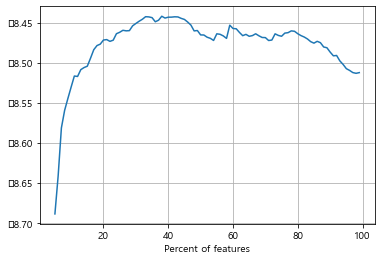

In [433]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = Ridge(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X_train_scaled, y_train)    #SelectPercentile: 지정된 비율만큼 특성을 선택한다.
    cv_score = cross_val_score(model, X_new, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [436]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(X_train_scaled, y_train)
X_train_select = fs.transform(X_train_scaled)
X_test_select = fs.transform(X_test_scaled)

In [437]:
print(X_train_select.shape)
print(X_train_nothuman.columns[fs.get_support()].tolist()) #get_support: 선택한 특성을 불린값으로 보여줘서 어떤 특성을 선택했는지 알 수 있다.

(21587, 440)
['10_stf', '11_stf', '12_stf', '13_stf', '14_stf', '15_stf', '16_stf', '17_stf', 'bf_work', 'shop_time', 'floor', 'af_work_rate', 'bf_work_rate', 'af_sales', 'mo_sales', 'refund_freq', 'sales_freq', 'all_freq', 'sales_dayofweek', 'sales_freq_mean', 'sales_import', 'fall_sales_x', 'spring_sales_x', 'summer_sales_x', 'winter_sales_x', 'fall_sales_y', 'spring_sales_y', 'summer_sales_y', 'winter_sales_y', 'summer_sales', 'sales_summer_rate', 'refund_summer_rate', 'wd_sales_rate', 'mon_sale_sm1', 'mon_sale_sm2', 'mon_sale_sm4', 'mon_sale_sm5', 'mon_sale_sm6', 'mon_sale_sm7', 'mon_sale_sm8', 'mon_sale_sm10', 'mon_sale_sm11', 'mon_sale_sm12', 'mon_sale_mn5', 'mon_sale_mn7', '1_mmff', '2_mmff', '4_mmff', '5_mmff', '6_mmff', '7_mmff', '8_mmff', '9_mmff', '10_mmff', '11_mmff', '12_mmff', 'net_amt', 'tot_sales_all', 'mean_amt_all', 'tot_sales', 'max_sales_amt', 'mean_sales_amt', 'tot_refund', 'min_refund_amt', 'mean_refund_amt', 'tot_sales_freq_mean', 'tot_dis_amt', 'mean_dis', 'dis_

# 앙상블

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from tensorflow import keras
from scipy.stats.mstats import gmean
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")    

### LGBM HP tuning

In [296]:
ftr = X_train_select
target =  y['age']

In [297]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((15110, 1239), (6477, 1239))

In [298]:
from bayes_opt import BayesianOptimization

In [299]:
bayesian_params = {
    'max_depth':(8, 16),
    'num_leaves':(24, 64),
    'min_child_samples':(10, 200),
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1),
    'colsample_bytree':(0.5, 1),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha':(0.01, 50)
}

In [300]:
def lgb_rmse_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree, max_bin, reg_lambda, reg_alpha):
    
    params = {
        "n_estimators":2000, 
        "learning_rate":0.02,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    
    lgb_model = LGBMRegressor(**params)
    lgb_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'RMSE', verbose= 100, 
                early_stopping_rounds= 100)
    valid_pred = lgb_model.predict(valid_x)
    RMSE = np.sqrt(mean_squared_error(valid_y, valid_pred))
    
    return RMSE

In [301]:
lgbBO = BayesianOptimization(f=lgb_rmse_eval, pbounds=bayesian_params, random_state=0)
lgbBO.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 7.51938	training's l2: 56.5411	valid_1's rmse: 8.2567	valid_1's l2: 68.1731
[200]	training's rmse: 6.67524	training's l2: 44.5588	valid_1's rmse: 8.05351	valid_1's l2: 64.859
[300]	training's rmse: 6.0802	training's l2: 36.9688	valid_1's rmse: 8.00891	valid_1's l2: 64.1426
[400]	training's rmse: 5.57891	training's l2: 31.1243	valid_1's rmse: 7.99358	valid_1's l2: 63.8973
[500]	training's rmse: 5.14195	training's l2: 26.4396	valid_1's rmse: 7.98879	valid_1's l2: 63.8208
Early stopping, best iteration is:
[475]	training's rmse: 5.24707	training's l2: 27.5317	valid_1's rmse: 7.98717	valid_1's l2: 63.7948
|  1        |  7.987    |  0.7744   | 

[400]	training's rmse: 5.33858	training's l2: 28.5005	valid_1's rmse: 8.00867	valid_1's l2: 64.1388
[500]	training's rmse: 4.8745	training's l2: 23.7608	valid_1's rmse: 8.0054	valid_1's l2: 64.0865
Early stopping, best iteration is:
[496]	training's rmse: 4.89223	training's l2: 23.9339	valid_1's rmse: 8.00436	valid_1's l2: 64.0698
|  8        |  8.004    |  1.0      |  439.4    |  16.0     |  155.8    |  19.67    |  59.17    |  6.849    |  5.148    |  0.852    |
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 7.48316	training's l2: 55.9976	valid_1's rmse: 8.24482	valid_1's l2: 67.9771
[200]	training's rmse: 6.73863	training's l2: 45.4092	valid_1's rmse: 8.0602	valid_1's l2: 64.9668
[300]	training's rmse: 6.35401	training's l2: 40.3734	valid_1's rmse: 8.02152	valid_1's l2: 64.3447
[400]	training's rmse: 6.05321	training's l2: 36.6414	valid_1's rmse: 8.00311	valid_1's l2: 64.0498
[500]	training's rmse: 5.78167	training's l2: 33.4277	valid_1's rmse: 7.

[200]	training's rmse: 6.55208	training's l2: 42.9298	valid_1's rmse: 8.04675	valid_1's l2: 64.7501
[300]	training's rmse: 5.92231	training's l2: 35.0737	valid_1's rmse: 8.00053	valid_1's l2: 64.0085
[400]	training's rmse: 5.40092	training's l2: 29.17	valid_1's rmse: 7.98885	valid_1's l2: 63.8217
[500]	training's rmse: 4.95548	training's l2: 24.5568	valid_1's rmse: 7.98353	valid_1's l2: 63.7367
[600]	training's rmse: 4.57504	training's l2: 20.931	valid_1's rmse: 7.98452	valid_1's l2: 63.7525
[700]	training's rmse: 4.22719	training's l2: 17.8692	valid_1's rmse: 7.98236	valid_1's l2: 63.7181
[800]	training's rmse: 3.92203	training's l2: 15.3823	valid_1's rmse: 7.98375	valid_1's l2: 63.7402
Early stopping, best iteration is:
[707]	training's rmse: 4.2043	training's l2: 17.6761	valid_1's rmse: 7.98105	valid_1's l2: 63.6971
|  16       |  7.981    |  0.6926   |  443.6    |  15.97    |  156.2    |  22.23    |  56.56    |  0.1986   |  2.602    |  0.6324   |
Training until validation scores do

[800]	training's rmse: 4.33513	training's l2: 18.7934	valid_1's rmse: 7.97809	valid_1's l2: 63.6499
Early stopping, best iteration is:
[731]	training's rmse: 4.52072	training's l2: 20.4369	valid_1's rmse: 7.97543	valid_1's l2: 63.6074
|  23       |  7.975    |  0.5971   |  447.9    |  13.87    |  168.5    |  19.35    |  51.06    |  4.679    |  6.172    |  0.6255   |
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 7.59359	training's l2: 57.6626	valid_1's rmse: 8.27085	valid_1's l2: 68.4069
[200]	training's rmse: 6.80535	training's l2: 46.3128	valid_1's rmse: 8.07609	valid_1's l2: 65.2233
[300]	training's rmse: 6.25342	training's l2: 39.1053	valid_1's rmse: 8.0246	valid_1's l2: 64.3941
[400]	training's rmse: 5.79807	training's l2: 33.6177	valid_1's rmse: 8.00542	valid_1's l2: 64.0867
[500]	training's rmse: 5.40227	training's l2: 29.1845	valid_1's rmse: 7.99738	valid_1's l2: 63.9582
[600]	training's rmse: 5.05297	training's l2: 25.5325	valid_1's rmse: 

Early stopping, best iteration is:
[747]	training's rmse: 5.06072	training's l2: 25.6109	valid_1's rmse: 7.96223	valid_1's l2: 63.3971
|  30       |  7.962    |  0.6136   |  431.9    |  9.192    |  165.5    |  19.27    |  52.59    |  7.53     |  7.167    |  0.8966   |


In [302]:
lgbBO.res

[{'target': 7.987165508847268,
  'params': {'colsample_bytree': 0.7744067519636624,
   'max_bin': 360.44278952248555,
   'max_depth': 12.822107008573152,
   'min_child_samples': 113.52780476941041,
   'min_child_weight': 21.75908516760633,
   'num_leaves': 49.835764522666246,
   'reg_alpha': 21.884984691022,
   'reg_lambda': 8.917838234820016,
   'subsample': 0.9818313802505146}},
 {'target': 7.979492120448154,
  'params': {'colsample_bytree': 0.6917207594128889,
   'max_bin': 397.94526866050563,
   'max_depth': 12.231159358023236,
   'min_child_samples': 117.92846660784714,
   'min_child_weight': 46.35423527634039,
   'num_leaves': 26.841442327915477,
   'reg_alpha': 4.36559369208002,
   'reg_lambda': 0.20316375600581688,
   'subsample': 0.916309922773969}},
 {'target': 8.005161819920833,
  'params': {'colsample_bytree': 0.8890783754749252,
   'max_bin': 436.30595264094137,
   'max_depth': 15.828946737862111,
   'min_child_samples': 161.8401272011775,
   'min_child_weight': 23.6124887

In [303]:
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmin(np.array(target_list)))

[7.987165508847268, 7.979492120448154, 8.005161819920833, 8.001034158959296, 7.984131121469482, 7.979372983288738, 7.996563996319494, 8.004364055621693, 7.986371279904021, 7.974529789982075, 7.973188262204542, 7.992036975456488, 7.995508391479316, 7.996287337381436, 7.994414305309304, 7.9810490082537955, 7.998604429084676, 7.984906536868514, 7.977370559867514, 7.983486085076981, 8.00253667772943, 7.9956457491130735, 7.975425732419744, 7.993256473785115, 8.004949738371579, 7.982482845492641, 7.990317183933471, 7.978914043426273, 7.97055606469109, 7.962228403815961]
maximum target index: 29


In [304]:
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmin(np.array(target_list))]
print(max_dict)

{'target': 7.962228403815961, 'params': {'colsample_bytree': 0.6135677219430125, 'max_bin': 431.8568693529485, 'max_depth': 9.192474991886744, 'min_child_samples': 165.51271062603092, 'min_child_weight': 19.273181779562222, 'num_leaves': 52.585047034434965, 'reg_alpha': 7.529604471620047, 'reg_lambda': 7.167466400758902, 'subsample': 0.89656117567388}}


In [423]:
ftr = X_train_select
target =  y['age']

In [424]:
from sklearn.model_selection import KFold

def train_apps_all_with_oof(ftr, target, nfolds=5):
    ftr = ftr
    target = target

    # nfolds 개의 cross validatin fold set을 가지는 KFold 생성 
    folds = KFold(n_splits=nfolds, shuffle=True, random_state=0)
    
    # Out of Folds로 학습된 모델의 validation set을 예측하여 결과 확률을 담을 array 생성.
    # validation set가 n_split갯수만큼 있으므로 크기는 ftr_app의 크기가 되어야 함. 
    oof_preds = np.zeros((ftr.shape[0],))  
    
    # Ouf of Folds로 학습된 모델의 test dataset을 예측하여 결과 확률을 담을 array 생성. 
    test_preds = np.zeros(((X_test_select.shape[0],)))
    
    # n_estimators를 4000까지 확대. 
    clf = LGBMRegressor(
                nthread=4,
                n_estimators=4000,
                learning_rate=0.01,
                max_depth=14,
                num_leaves=43,
                colsample_bytree=0.6243940572960339,
                subsample=0.9456256393571061,
                max_bin=308,
                reg_alpha=40.75532541032781,
                reg_lambda=1.3974457528318784,
                min_child_weight=10.700102581559948,
                min_child_samples=140,
                silent=-1,
                verbose=-1,
                )


    # nfolds 번 cross validation Iteration 반복하면서 OOF 방식으로 학습 및 테스트 데이터 예측
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr)):
        print('##### iteration ', fold_idx, ' 시작')
        # 학습용 데이터 세트의 인덱스와 검증용 데이터 세트의 인덱스 추출하여 이를 기반으로 학습/검증 데이터 추출
        train_x = ftr.iloc[train_idx, :]
        train_y = target.iloc[train_idx]
        valid_x = ftr.iloc[valid_idx, :]
        valid_y = target.iloc[valid_idx]
        
        # 추출된 학습/검증 데이터 세트로 모델 학습. early_stopping은 200으로 증가. 
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'RMSE', verbose= 200, 
                early_stopping_rounds= 200)
        # 검증 데이터 세트로 예측된 확률 저장. 사용되지는 않음. 
        #oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration_)       
        # 학습된 모델로 테스트 데이터 세트에 예측 확률 계산. 
        # nfolds 번 반복 실행하므로 평균 확률을 구하기 위해 개별 수행시 마다 수행 횟수로 나눈 확률을 추후에 더해서 최종 평균 확률 계산. 
        test_preds += clf.predict(X_test_select, num_iteration=clf.best_iteration_)/folds.n_splits
        
        
    return clf, test_preds

In [426]:
clf, test_preds = train_apps_all_with_oof(ftr, target, nfolds=5)

##### iteration  0  시작
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 7.5716	training's l2: 57.3292	valid_1's rmse: 8.28327	valid_1's l2: 68.6125
[400]	training's rmse: 6.8237	training's l2: 46.5629	valid_1's rmse: 8.0948	valid_1's l2: 65.5258
[600]	training's rmse: 6.42053	training's l2: 41.2232	valid_1's rmse: 8.05453	valid_1's l2: 64.8754
[800]	training's rmse: 6.10941	training's l2: 37.3249	valid_1's rmse: 8.03856	valid_1's l2: 64.6184
[1000]	training's rmse: 5.81739	training's l2: 33.8421	valid_1's rmse: 8.02758	valid_1's l2: 64.4421
[1200]	training's rmse: 5.55747	training's l2: 30.8854	valid_1's rmse: 8.02152	valid_1's l2: 64.3447
[1400]	training's rmse: 5.3196	training's l2: 28.2981	valid_1's rmse: 8.01917	valid_1's l2: 64.3071
[1600]	training's rmse: 5.10682	training's l2: 26.0796	valid_1's rmse: 8.01767	valid_1's l2: 64.283
Early stopping, best iteration is:
[1497]	training's rmse: 5.21024	training's l2: 27.1466	valid_1's rmse: 8.01526	va

In [308]:
test_preds

array([40.73266126, 44.74888879, 27.71824792, ..., 36.95008037,
       33.93506517, 26.72884366])

In [309]:
t = pd.Timestamp.now()
fname = f"submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="custid"), pd.Series(test_preds, name="age")] ,axis=1)
submissions.to_csv(fname, index=False)
print("'{}' is ready to submit." .format(fname))

'submission_0615_0327.csv' is ready to submit.


### xgboost HP tuning

In [310]:
ftr = X_train_select
target =  y['age']

In [311]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((15110, 1239), (6477, 1239))

In [312]:
from bayes_opt import BayesianOptimization

In [313]:
bayesian_params = {
    'n_estimators': (1804, 1806),
     'gamma': (0, 100),
     'max_depth' : (8, 16),
     'min_child_weight': (1, 50),
     'max_delta_step': (1, 50),
     'subsample': (0.5, 1),
     'colsample_bytree': (0.5, 1),
     'colsample_bylevel': (0.5, 1),
     'reg_lambda': (0.001, 10),
}

In [315]:
def xgb_rmse_eval(n_estimators, gamma, max_depth, min_child_weight, max_delta_step, 
                subsample, colsample_bytree, colsample_bylevel, reg_lambda):
    
    params = {
        "n_estimators":int(round(n_estimators)), 
        "learning_rate":0.02,
        'gamma':int(round(gamma)),
        'max_depth':int(round(max_depth)),
        'min_child_weight': int(round(min_child_weight)),
        'max_delta_step': int(round(max_delta_step)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': max(reg_lambda,0),
        'colsample_bylevel':max(min(colsample_bylevel, 1), 0)
    }
    
    xgb_model = XGBRegressor(**params)
    xgb_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'rmse', verbose= 100, 
                early_stopping_rounds= 100)
    valid_pred = xgb_model.predict(valid_x)
    RMSE = np.sqrt(mean_squared_error(valid_y, valid_pred))
    
    return RMSE

In [316]:
xgbBO = BayesianOptimization(f=xgb_rmse_eval, pbounds=bayesian_params, random_state=0)
xgbBO.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... | colsam... |   gamma   | max_de... | max_depth | min_ch... | n_esti... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[0]	validation_0-rmse:36.06340	validation_1-rmse:35.83922
[100]	validation_0-rmse:8.87136	validation_1-rmse:9.70564
[200]	validation_0-rmse:5.29508	validation_1-rmse:8.09067
[300]	validation_0-rmse:4.33195	validation_1-rmse:8.01332
[400]	validation_0-rmse:3.80262	validation_1-rmse:7.99972
[500]	validation_0-rmse:3.31632	validation_1-rmse:7.99312
[600]	validation_0-rmse:2.93917	validation_1-rmse:7.98979
[700]	validation_0-rmse:2.64273	validation_1-rmse:7.98760
[800]	validation_0-rmse:2.39303	validation_1-rmse:7.98654
[860]	validation_0-rmse:2.28410	validation_1-rmse:7.98673
|  1        |  7.985    |  0.7744   |  0.8576   |  60.28    |  27.7     |  11.39    |  32.65    |  1.805e+0 |  8.918    |  0.9818   |
[0]	validation_0-r

|  9        |  8.019    |  1.0      |  0.5      |  39.65    |  50.0     |  8.0      |  1.0      |  1.806e+0 |  10.0     |  0.5      |
[0]	validation_0-rmse:35.89865	validation_1-rmse:35.68850
[100]	validation_0-rmse:5.99838	validation_1-rmse:9.22768
[200]	validation_0-rmse:2.28253	validation_1-rmse:8.05553
[300]	validation_0-rmse:1.65159	validation_1-rmse:8.03955
[400]	validation_0-rmse:1.34207	validation_1-rmse:8.03757
[476]	validation_0-rmse:1.19134	validation_1-rmse:8.03879
|  10       |  8.037    |  0.5      |  1.0      |  19.54    |  50.0     |  16.0     |  17.01    |  1.804e+0 |  0.001    |  1.0      |
[0]	validation_0-rmse:36.06340	validation_1-rmse:35.83922
[100]	validation_0-rmse:6.31818	validation_1-rmse:9.62989
[200]	validation_0-rmse:1.87861	validation_1-rmse:8.12810
[300]	validation_0-rmse:1.46742	validation_1-rmse:8.09138
[400]	validation_0-rmse:1.39863	validation_1-rmse:8.08601
[500]	validation_0-rmse:1.36401	validation_1-rmse:8.08294
[600]	validation_0-rmse:1.33859	vali

[1803]	validation_0-rmse:0.86395	validation_1-rmse:8.11439
|  17       |  8.114    |  1.0      |  0.5      |  17.93    |  36.16    |  16.0     |  1.0      |  1.804e+0 |  10.0     |  1.0      |
[0]	validation_0-rmse:35.93428	validation_1-rmse:35.70999
[100]	validation_0-rmse:8.51595	validation_1-rmse:9.73218
[200]	validation_0-rmse:4.15781	validation_1-rmse:8.15273
[300]	validation_0-rmse:2.75313	validation_1-rmse:8.04786
[400]	validation_0-rmse:2.03103	validation_1-rmse:8.03228
[500]	validation_0-rmse:1.62759	validation_1-rmse:8.02822
[600]	validation_0-rmse:1.42220	validation_1-rmse:8.02559
[700]	validation_0-rmse:1.31621	validation_1-rmse:8.02342
[800]	validation_0-rmse:1.25402	validation_1-rmse:8.02216
[900]	validation_0-rmse:1.21402	validation_1-rmse:8.02185
[1000]	validation_0-rmse:1.18952	validation_1-rmse:8.02172
[1041]	validation_0-rmse:1.18100	validation_1-rmse:8.02163
|  18       |  8.021    |  0.8726   |  0.802    |  26.98    |  38.83    |  15.19    |  6.825    |  1.806e+0 |

[300]	validation_0-rmse:1.38830	validation_1-rmse:8.09331
[400]	validation_0-rmse:1.13557	validation_1-rmse:8.08512
[500]	validation_0-rmse:1.04162	validation_1-rmse:8.08188
[600]	validation_0-rmse:0.99433	validation_1-rmse:8.08012
[700]	validation_0-rmse:0.96575	validation_1-rmse:8.07912
[800]	validation_0-rmse:0.94854	validation_1-rmse:8.07857
[900]	validation_0-rmse:0.93444	validation_1-rmse:8.07771
[1000]	validation_0-rmse:0.92517	validation_1-rmse:8.07750
[1046]	validation_0-rmse:0.92063	validation_1-rmse:8.07750
|  27       |  8.077    |  0.8738   |  0.9544   |  19.59    |  47.38    |  14.95    |  1.35     |  1.805e+0 |  1.818    |  0.7323   |
[0]	validation_0-rmse:35.94818	validation_1-rmse:35.72638
[100]	validation_0-rmse:6.46825	validation_1-rmse:9.58844
[200]	validation_0-rmse:2.14401	validation_1-rmse:8.12038
[300]	validation_0-rmse:1.37342	validation_1-rmse:8.07083
[400]	validation_0-rmse:1.15869	validation_1-rmse:8.06545
[500]	validation_0-rmse:1.07564	validation_1-rmse:8.

In [317]:
xgbBO.res

[{'target': 7.985279821547924,
  'params': {'colsample_bylevel': 0.7744067519636624,
   'colsample_bytree': 0.8575946831862098,
   'gamma': 60.276337607164386,
   'max_delta_step': 27.699275966847946,
   'max_depth': 11.389238394711239,
   'min_child_weight': 32.64881154026615,
   'n_estimators': 1804.8751744225253,
   'reg_lambda': 8.917838234820016,
   'subsample': 0.9818313802505146}},
 {'target': 8.039493857355893,
  'params': {'colsample_bylevel': 0.6917207594128889,
   'colsample_bytree': 0.8958625190413323,
   'gamma': 52.88949197529045,
   'max_delta_step': 28.834183493602684,
   'max_depth': 15.404773106341288,
   'min_child_weight': 4.48076685169646,
   'n_estimators': 1804.1742585994032,
   'reg_lambda': 0.20316375600581688,
   'subsample': 0.916309922773969}},
 {'target': 7.987958221777498,
  'params': {'colsample_bylevel': 0.8890783754749252,
   'colsample_bytree': 0.9350060741234096,
   'gamma': 97.8618342232764,
   'max_delta_step': 40.158769646619454,
   'max_depth': 11

In [318]:
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in xgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmin(np.array(target_list)))

[7.985279821547924, 8.039493857355893, 7.987958221777498, 8.004578012351246, 7.9667055983526565, 8.066990347195242, 8.087074141454277, 8.020138691469592, 8.019474864959104, 8.03740093982891, 8.075162485065709, 8.114785340497294, 8.06818526895114, 8.141043051195755, 7.986033131114647, 8.151511845430413, 8.114367418846463, 8.021364567686216, 8.08858086681745, 8.12825112250086, 8.172066407069503, 8.352975233349872, 8.10101170712333, 8.38046702776314, 8.032386848398877, 8.03573596881236, 8.077220009036964, 8.059329786618648, 8.060558628145293, 8.102708572220232]
maximum target index: 4


In [319]:
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = xgbBO.res[np.argmin(np.array(target_list))]
print(max_dict)

{'target': 7.9667055983526565, 'params': {'colsample_bylevel': 0.8060478613612108, 'colsample_bytree': 0.8084669984373785, 'gamma': 94.37480785146242, 'max_delta_step': 34.40919465607069, 'max_depth': 10.876063204590288, 'min_child_weight': 22.41456573616773, 'n_estimators': 1805.3952623918544, 'reg_lambda': 0.6031944908210691, 'subsample': 0.8333833577228338}}


In [428]:
ftr = X_train_select
target =  y['age']

In [429]:
from sklearn.model_selection import KFold

def train_apps_all_with_oof(ftr, target, nfolds=5):
    ftr = ftr
    target = target

    # nfolds 개의 cross validatin fold set을 가지는 KFold 생성 
    folds = KFold(n_splits=nfolds, shuffle=True, random_state=0)
    
    # Out of Folds로 학습된 모델의 validation set을 예측하여 결과 확률을 담을 array 생성.
    # validation set가 n_split갯수만큼 있으므로 크기는 ftr_app의 크기가 되어야 함. 
    oof_preds = np.zeros((ftr.shape[0],))  
    
    # Ouf of Folds로 학습된 모델의 test dataset을 예측하여 결과 확률을 담을 array 생성. 
    test_preds = np.zeros(((X_test_select.shape[0],)))
    
    # n_estimators를 4000까지 확대. 
    clf = XGBRegressor(subsample =  0.5716766437045232, 
                       silent = -1, reg_lambda = 6.3995702922539115, 
                       n_estimators = 1804, min_child_weight = 39.245929638036316, 
                       max_depth = 12, learning_rate = 0.01, gamma = 97.8618342232764, 
                       colsample_bytree = 0.9350060741234096, colsample_bylevel = 0.8890783754749252,
                       max_delta_step= 40.158769646619454)


    # nfolds 번 cross validation Iteration 반복하면서 OOF 방식으로 학습 및 테스트 데이터 예측
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr)):
        print('##### iteration ', fold_idx, ' 시작')
        # 학습용 데이터 세트의 인덱스와 검증용 데이터 세트의 인덱스 추출하여 이를 기반으로 학습/검증 데이터 추출
        train_x = ftr.iloc[train_idx, :]
        train_y = target.iloc[train_idx]
        valid_x = ftr.iloc[valid_idx, :]
        valid_y = target.iloc[valid_idx]
        
        # 추출된 학습/검증 데이터 세트로 모델 학습. early_stopping은 200으로 증가. 
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'rmse', verbose= 200, 
                early_stopping_rounds= 200)
        # 검증 데이터 세트로 예측된 확률 저장. 사용되지는 않음. 
        #oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration_)       
        # 학습된 모델로 테스트 데이터 세트에 예측 확률 계산. 
        # nfolds 번 반복 실행하므로 평균 확률을 구하기 위해 개별 수행시 마다 수행 횟수로 나눈 확률을 추후에 더해서 최종 평균 확률 계산. 
        test_preds += clf.predict(X_test_select)/folds.n_splits
        
        
    return clf, test_preds

In [430]:
clf, test_preds = train_apps_all_with_oof(ftr, target, nfolds=5)

##### iteration  0  시작
[0]	validation_0-rmse:36.22778	validation_1-rmse:36.17917
[200]	validation_0-rmse:7.43421	validation_1-rmse:9.43116
[400]	validation_0-rmse:4.20120	validation_1-rmse:8.08235
[600]	validation_0-rmse:3.56227	validation_1-rmse:8.04700
[800]	validation_0-rmse:3.15434	validation_1-rmse:8.03798
[1000]	validation_0-rmse:2.84083	validation_1-rmse:8.03036
[1200]	validation_0-rmse:2.59923	validation_1-rmse:8.02655
[1400]	validation_0-rmse:2.43166	validation_1-rmse:8.02384
[1600]	validation_0-rmse:2.31390	validation_1-rmse:8.02187
[1799]	validation_0-rmse:2.23409	validation_1-rmse:8.02146
##### iteration  1  시작
[0]	validation_0-rmse:36.27621	validation_1-rmse:35.98660
[200]	validation_0-rmse:7.45058	validation_1-rmse:9.36272
[400]	validation_0-rmse:4.18650	validation_1-rmse:7.90817
[600]	validation_0-rmse:3.53523	validation_1-rmse:7.85063
[800]	validation_0-rmse:3.13855	validation_1-rmse:7.83588
[1000]	validation_0-rmse:2.84510	validation_1-rmse:7.82856
[1200]	validation_0-

KeyboardInterrupt: 

In [345]:
test_preds

array([39.86416674, 42.71971416, 28.57365751, ..., 36.07904482,
       34.42722082, 26.97699118])

In [346]:
t = pd.Timestamp.now()
fname = f"submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="custid"), pd.Series(test_preds, name="age")] ,axis=1)
submissions.to_csv(fname, index=False)
print("'{}' is ready to submit." .format(fname))

'submission_0615_1118.csv' is ready to submit.


###  Catboost

In [ ]:
ftr = X_train_select
target =  y['age']

In [ ]:
from sklearn.model_selection import KFold

def train_apps_all_with_oof(ftr, target, nfolds=5):
    ftr = ftr
    target = target

    # nfolds 개의 cross validatin fold set을 가지는 KFold 생성 
    folds = KFold(n_splits=nfolds, shuffle=True, random_state=0)
    
    # Out of Folds로 학습된 모델의 validation set을 예측하여 결과 확률을 담을 array 생성.
    # validation set가 n_split갯수만큼 있으므로 크기는 ftr_app의 크기가 되어야 함. 
    oof_preds = np.zeros((ftr.shape[0],))  
    
    # Ouf of Folds로 학습된 모델의 test dataset을 예측하여 결과 확률을 담을 array 생성. 
    test_preds = np.zeros(((X_test_select.shape[0],)))
    
    # n_estimators를 4000까지 확대. 
    clf = CatBoostRegressor(random_state=0,eval_metric='RMSE',loss_function='RMSE')

    # nfolds 번 cross validation Iteration 반복하면서 OOF 방식으로 학습 및 테스트 데이터 예측
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr)):
        print('##### iteration ', fold_idx, ' 시작')
        # 학습용 데이터 세트의 인덱스와 검증용 데이터 세트의 인덱스 추출하여 이를 기반으로 학습/검증 데이터 추출
        train_x = ftr.iloc[train_idx, :]
        train_y = target.iloc[train_idx]
        valid_x = ftr.iloc[valid_idx, :]
        valid_y = target.iloc[valid_idx]
        
        # 추출된 학습/검증 데이터 세트로 모델 학습. early_stopping은 200으로 증가. 
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], use_best_model=True, verbose= 200, 
                early_stopping_rounds= 200)
        # 검증 데이터 세트로 예측된 확률 저장. 사용되지는 않음. 
        #oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration_)       
        # 학습된 모델로 테스트 데이터 세트에 예측 확률 계산. 
        # nfolds 번 반복 실행하므로 평균 확률을 구하기 위해 개별 수행시 마다 수행 횟수로 나눈 확률을 추후에 더해서 최종 평균 확률 계산. 
        test_preds += clf.predict(X_test_select)/folds.n_splits
        
        
    return clf, test_preds

In [ ]:
clf, test_preds = train_apps_all_with_oof(ftr, target, nfolds=5)

In [367]:
test_preds

array([38.82502123, 42.54239728, 27.3671957 , ..., 38.33219587,
       33.4536716 , 28.00149744])

In [368]:
t = pd.Timestamp.now()
fname = f"submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="custid"), pd.Series(test_preds, name="age")] ,axis=1)
submissions.to_csv(fname, index=False)
print("'{}' is ready to submit." .format(fname))

'submission_0615_1156.csv' is ready to submit.


###  릿지 HP tuning

In [379]:
ftr = X_train_select
target =  y['age']

In [380]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((15110, 1239), (6477, 1239))

In [377]:
from sklearn.model_selection import KFold

def train_apps_all_with_oof(ftr, target, nfolds=5):
    ftr = ftr
    target = target

    # nfolds 개의 cross validatin fold set을 가지는 KFold 생성 
    folds = KFold(n_splits=nfolds, shuffle=True, random_state=0)
    
    # Out of Folds로 학습된 모델의 validation set을 예측하여 결과 확률을 담을 array 생성.
    # validation set가 n_split갯수만큼 있으므로 크기는 ftr_app의 크기가 되어야 함. 
    oof_preds = np.zeros((ftr.shape[0],))  
    
    # Ouf of Folds로 학습된 모델의 test dataset을 예측하여 결과 확률을 담을 array 생성. 
    test_preds = np.zeros(((X_test_select.shape[0],)))
    
    # n_estimators를 4000까지 확대. 
    clf = Ridge(alpha=37)

    # nfolds 번 cross validation Iteration 반복하면서 OOF 방식으로 학습 및 테스트 데이터 예측
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr)):
        print('##### iteration ', fold_idx, ' 시작')
        # 학습용 데이터 세트의 인덱스와 검증용 데이터 세트의 인덱스 추출하여 이를 기반으로 학습/검증 데이터 추출
        train_x = ftr[train_idx, :]
        train_y = target[train_idx]
        valid_x = ftr[valid_idx, :]
        valid_y = target[valid_idx]
        
        # 추출된 학습/검증 데이터 세트로 모델 학습. early_stopping은 200으로 증가. 
        clf.fit(train_x, train_y)
        # 검증 데이터 세트로 예측된 확률 저장. 사용되지는 않음. 
        #oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration_)       
        # 학습된 모델로 테스트 데이터 세트에 예측 확률 계산. 
        # nfolds 번 반복 실행하므로 평균 확률을 구하기 위해 개별 수행시 마다 수행 횟수로 나눈 확률을 추후에 더해서 최종 평균 확률 계산. 
        test_preds += clf.predict(X_test_select)/folds.n_splits
        print(np.sqrt(mean_squared_error(valid_y, clf.predict(valid_x))))
        
        
    return clf, test_preds

In [ ]:
clf, test_preds = train_apps_all_with_oof(ftr, target, nfolds=5)

In [421]:
test_preds

array([35.78818772, 42.74331594, 28.4787379 , ..., 34.54083888,
       35.01098712, 28.26364696])

In [422]:
t = pd.Timestamp.now()
fname = f"submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="custid"), pd.Series(test_preds, name="age")] ,axis=1)
submissions.to_csv(fname, index=False)
print("'{}' is ready to submit." .format(fname))

'submission_0615_1232.csv' is ready to submit.


### LGBM 서치

In [441]:
models=[]

In [442]:
ftr = X_train_select
target =  y['age']

In [443]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((15110, 1239), (6477, 1239))

In [444]:
# LGBM
model =LGBMRegressor(
                nthread=4,
                n_estimators=4000,
                learning_rate=0.01,
                max_depth=14,
                num_leaves=43,
                colsample_bytree=0.6243940572960339,
                subsample=0.9456256393571061,
                max_bin=308,
                reg_alpha=40.75532541032781,
                reg_lambda=1.3974457528318784,
                min_child_weight=10.700102581559948,
                min_child_samples=140,
                silent=-1,
                verbose=-1,
                )

model.fit(train_x, train_y, verbose=False)
print(np.sqrt(mean_squared_error(valid_y, model.predict(valid_x))))

models.append(model)

7.9829445617967165


### Catboost 서치

In [452]:
ftr = X_train_select
target =  y['age']

In [453]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((15110, 1239), (6477, 1239))

In [454]:
# CatBoost
model = CatBoostRegressor(random_state=0,eval_metric='RMSE',loss_function='RMSE')
model.fit(train_x, train_y, verbose=False)
print(np.sqrt(mean_squared_error(valid_y, model.predict(valid_x))))

models.append(model)

8.020228654289912


###  Ridge 서치

In [455]:
ftr = X_train_select
target =  y['age']

In [456]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((15110, 1239), (6477, 1239))

In [457]:
# Ridge
model = Ridge(alpha=37)
model.fit(train_x, train_y)
print(np.sqrt(mean_squared_error(valid_y, model.predict(valid_x))))
models.append(model)

8.396088295738776


### XGBM 서치

In [458]:
ftr = X_train_select
target =  y['age']

In [459]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((15110, 1239), (6477, 1239))

In [460]:
# Ridge
model =  XGBRegressor(subsample =  0.5716766437045232, 
                       silent = -1, reg_lambda = 6.3995702922539115, 
                       n_estimators = 1804, min_child_weight = 39.245929638036316, 
                       max_depth = 12, learning_rate = 0.01, gamma = 97.8618342232764, 
                       colsample_bytree = 0.9350060741234096, colsample_bylevel = 0.8890783754749252,
                       max_delta_step= 40.158769646619454)
model.fit(train_x, train_y)
print(np.sqrt(mean_squared_error(valid_y, model.predict(valid_x))))
models.append(model)

7.981946335709951


In [476]:
models

[LGBMRegressor(colsample_bytree=0.61357, learning_rate=0.01, max_bin=431,
               max_depth=9, min_child_samples=165, min_child_weight=19.2731,
               n_estimators=4000, nthread=4, num_leaves=53, reg_alpha=7.5296,
               reg_lambda=7.167, silent=-1, subsample=0.8966, verbose=-1),
 BayesianRidge(alpha_1=0.5657, alpha_2=0.3657, lambda_1=0.6798, lambda_2=0.4051),
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.806,
              colsample_bynode=1, colsample_bytree=0.8085, gamma=94.3748,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=34.4092, max_depth=11,
              min_child_weight=22.41457, missing=nan, monotone_constraints='()',
              n_estimators=1800, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=0.6032, scale_pos_weight=1,
              subsample=0.8334, tree_method='exact', validate_parameters=1,
              

### DNN

In [463]:
import pandas as pd
import numpy as np
import os
import random
import pickle
from tqdm import tqdm
from IPython.display import Image, clear_output
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import kerastuner as kt

In [470]:
ftr = X_train_select
target =  y['age']

In [472]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(ftr, target, test_size=0.3, random_state=0)
X_train.shape, X_valid.shape

((15110, 1239), (6477, 1239))

In [473]:
def experiment(i, h_size, num_hidden, activation, lr):
    model = tf.keras.Sequential()
    for _ in range(num_hidden):
        model.add(tf.keras.layers.Dense(h_size, activation=activation))
    model.add(tf.keras.layers.Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                 batch_size=128, epochs=300, callbacks=callbacks, shuffle=False, verbose=2)
    
    return min(hist.history['val_root_mean_squared_error'])

In [474]:
results = []
for i in range(3):
    h_sizes = [ 8, 16,32,64]
    h_size = np.random.choice(h_sizes)
    num_hidden = np.random.randint(0, 3)
    activation = np.random.choice(['relu'])
    lr = 10 ** np.random.randint(-5, 0)

    val_loss = experiment(i, h_size, num_hidden, activation, lr)
    results.append({
        'val_loss': val_loss,
        'h_size': h_size,
        'num_hidden': num_hidden,
        'activation': activation,
        'lr': lr
    })

Epoch 1/300

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



119/119 - 1s - loss: 55847.0820 - root_mean_squared_error: 236.3199 - val_loss: 51387.3203 - val_root_mean_squared_error: 226.6877
Epoch 2/300
119/119 - 1s - loss: 46789.5312 - root_mean_squared_error: 216.3089 - val_loss: 42890.5078 - val_root_mean_squared_error: 207.1002
Epoch 3/300
119/119 - 0s - loss: 38906.3242 - root_mean_squared_error: 197.2469 - val_loss: 35511.8789 - val_root_mean_squared_error: 188.4460
Epoch 4/300
119/119 - 1s - loss: 32082.7031 - root_mean_squared_error: 179.1165 - val_loss: 29147.9668 - val_root_mean_squared_error: 170.7278
Epoch 5/300
119/119 - 0s - loss: 26219.5996 - root_mean_squared_error: 161.9247 - val_loss: 23702.5098 - val_root_mean_squared_error: 153.9562
Epoch 6/300
119/119 - 0s - loss: 21223.8965 - root_mean_squared_error: 145.6842 - val_loss: 19084.2559 - val_root_mean_squared_error: 138.1458
Epoch 7/300
119/119 - 0s - loss: 17006.9844 - root_mean_squared_error: 130.4108 - val_loss: 15206.1475 - val_root_mean_squared_error: 123.3132
Epoch 8/300

119/119 - 0s - loss: 398.4903 - root_mean_squared_error: 19.9622 - val_loss: 382.6455 - val_root_mean_squared_error: 19.5613
Epoch 61/300
119/119 - 0s - loss: 393.6037 - root_mean_squared_error: 19.8394 - val_loss: 377.9179 - val_root_mean_squared_error: 19.4401
Epoch 62/300
119/119 - 0s - loss: 388.7182 - root_mean_squared_error: 19.7159 - val_loss: 373.1937 - val_root_mean_squared_error: 19.3182
Epoch 63/300
119/119 - 0s - loss: 383.8378 - root_mean_squared_error: 19.5918 - val_loss: 368.4764 - val_root_mean_squared_error: 19.1957
Epoch 64/300
119/119 - 0s - loss: 378.9663 - root_mean_squared_error: 19.4671 - val_loss: 363.7700 - val_root_mean_squared_error: 19.0728
Epoch 65/300
119/119 - 0s - loss: 374.1079 - root_mean_squared_error: 19.3419 - val_loss: 359.0778 - val_root_mean_squared_error: 18.9493
Epoch 66/300
119/119 - 0s - loss: 369.2654 - root_mean_squared_error: 19.2163 - val_loss: 354.4030 - val_root_mean_squared_error: 18.8256
Epoch 67/300
119/119 - 0s - loss: 364.4420 - ro

Epoch 120/300
119/119 - 0s - loss: 166.7730 - root_mean_squared_error: 12.9141 - val_loss: 160.5484 - val_root_mean_squared_error: 12.6708
Epoch 121/300
119/119 - 0s - loss: 164.2950 - root_mean_squared_error: 12.8178 - val_loss: 158.2099 - val_root_mean_squared_error: 12.5782
Epoch 122/300
119/119 - 0s - loss: 161.8632 - root_mean_squared_error: 12.7225 - val_loss: 155.9168 - val_root_mean_squared_error: 12.4867
Epoch 123/300
119/119 - 0s - loss: 159.4776 - root_mean_squared_error: 12.6284 - val_loss: 153.6690 - val_root_mean_squared_error: 12.3963
Epoch 124/300
119/119 - 0s - loss: 157.1380 - root_mean_squared_error: 12.5355 - val_loss: 151.4662 - val_root_mean_squared_error: 12.3072
Epoch 125/300
119/119 - 0s - loss: 154.8443 - root_mean_squared_error: 12.4436 - val_loss: 149.3084 - val_root_mean_squared_error: 12.2192
Epoch 126/300
119/119 - 0s - loss: 152.5961 - root_mean_squared_error: 12.3530 - val_loss: 147.1954 - val_root_mean_squared_error: 12.1324
Epoch 127/300
119/119 - 0s 

Epoch 180/300
119/119 - 0s - loss: 89.6505 - root_mean_squared_error: 9.4684 - val_loss: 89.6337 - val_root_mean_squared_error: 9.4675
Epoch 181/300
119/119 - 0s - loss: 89.2879 - root_mean_squared_error: 9.4492 - val_loss: 89.3239 - val_root_mean_squared_error: 9.4511
Epoch 182/300
119/119 - 0s - loss: 88.9412 - root_mean_squared_error: 9.4309 - val_loss: 89.0281 - val_root_mean_squared_error: 9.4355
Epoch 183/300
119/119 - 1s - loss: 88.6096 - root_mean_squared_error: 9.4133 - val_loss: 88.7455 - val_root_mean_squared_error: 9.4205
Epoch 184/300
119/119 - 0s - loss: 88.2923 - root_mean_squared_error: 9.3964 - val_loss: 88.4754 - val_root_mean_squared_error: 9.4061
Epoch 185/300
119/119 - 0s - loss: 87.9887 - root_mean_squared_error: 9.3802 - val_loss: 88.2171 - val_root_mean_squared_error: 9.3924
Epoch 186/300
119/119 - 0s - loss: 87.6981 - root_mean_squared_error: 9.3647 - val_loss: 87.9701 - val_root_mean_squared_error: 9.3792
Epoch 187/300
119/119 - 1s - loss: 87.4198 - root_mean_

Epoch 241/300
119/119 - 1s - loss: 80.3963 - root_mean_squared_error: 8.9664 - val_loss: 81.5067 - val_root_mean_squared_error: 9.0281
Epoch 242/300
119/119 - 1s - loss: 80.3245 - root_mean_squared_error: 8.9624 - val_loss: 81.4382 - val_root_mean_squared_error: 9.0243
Epoch 243/300
119/119 - 1s - loss: 80.2536 - root_mean_squared_error: 8.9584 - val_loss: 81.3705 - val_root_mean_squared_error: 9.0206
Epoch 244/300
119/119 - 1s - loss: 80.1836 - root_mean_squared_error: 8.9545 - val_loss: 81.3035 - val_root_mean_squared_error: 9.0168
Epoch 245/300
119/119 - 0s - loss: 80.1143 - root_mean_squared_error: 8.9507 - val_loss: 81.2373 - val_root_mean_squared_error: 9.0132
Epoch 246/300
119/119 - 0s - loss: 80.0459 - root_mean_squared_error: 8.9468 - val_loss: 81.1718 - val_root_mean_squared_error: 9.0095
Epoch 247/300
119/119 - 0s - loss: 79.9782 - root_mean_squared_error: 8.9431 - val_loss: 81.1071 - val_root_mean_squared_error: 9.0059
Epoch 248/300
119/119 - 0s - loss: 79.9113 - root_mean_


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



119/119 - 1s - loss: 10479.3896 - root_mean_squared_error: 102.3689 - val_loss: 81.8115 - val_root_mean_squared_error: 9.0450
Epoch 2/300
119/119 - 1s - loss: 81.0073 - root_mean_squared_error: 9.0004 - val_loss: 79.0262 - val_root_mean_squared_error: 8.8897
Epoch 3/300
119/119 - 1s - loss: 80.7780 - root_mean_squared_error: 8.9877 - val_loss: 82.4070 - val_root_mean_squared_error: 9.0778
Epoch 4/300
119/119 - 1s - loss: 80.2063 - root_mean_squared_error: 8.9558 - val_loss: 75.7367 - val_root_mean_squared_error: 8.7027
Epoch 5/300
119/119 - 1s - loss: 86.6749 - root_mean_squared_error: 9.3099 - val_loss: 106.9097 - val_root_mean_squared_error: 10.3397
Epoch 6/300
119/119 - 1s - loss: 92.4985 - root_mean_squared_error: 9.6176 - val_loss: 74.6331 - val_root_mean_squared_error: 8.6390
Epoch 7/300
119/119 - 1s - loss: 108.2411 - root_mean_squared_error: 10.4039 - val_loss: 117.9028 - val_root_mean_squared_error: 10.8583
Epoch 8/300
119/119 - 1s - loss: 109.3718 - root_mean_squared_error: 1


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



119/119 - 1s - loss: 512682.6562 - root_mean_squared_error: 716.0186 - val_loss: 500992.2812 - val_root_mean_squared_error: 707.8081
Epoch 2/300
119/119 - 0s - loss: 483593.2188 - root_mean_squared_error: 695.4087 - val_loss: 472392.5312 - val_root_mean_squared_error: 687.3082
Epoch 3/300
119/119 - 0s - loss: 455792.6250 - root_mean_squared_error: 675.1241 - val_loss: 445033.4375 - val_root_mean_squared_error: 667.1083
Epoch 4/300
119/119 - 0s - loss: 429197.0938 - root_mean_squared_error: 655.1313 - val_loss: 418860.3438 - val_root_mean_squared_error: 647.1942
Epoch 5/300
119/119 - 0s - loss: 403757.3438 - root_mean_squared_error: 635.4190 - val_loss: 393827.8125 - val_root_mean_squared_error: 627.5570
Epoch 6/300
119/119 - 0s - loss: 379430.6875 - root_mean_squared_error: 615.9794 - val_loss: 369895.0625 - val_root_mean_squared_error: 608.1900
Epoch 7/300
119/119 - 0s - loss: 356178.0000 - root_mean_squared_error: 596.8065 - val_loss: 347024.2500 - val_root_mean_squared_error: 589.08

Epoch 59/300
119/119 - 0s - loss: 664.8378 - root_mean_squared_error: 25.7844 - val_loss: 636.7288 - val_root_mean_squared_error: 25.2335
Epoch 60/300
119/119 - 1s - loss: 650.7987 - root_mean_squared_error: 25.5108 - val_loss: 625.1209 - val_root_mean_squared_error: 25.0024
Epoch 61/300
119/119 - 1s - loss: 641.3099 - root_mean_squared_error: 25.3241 - val_loss: 617.1852 - val_root_mean_squared_error: 24.8432
Epoch 62/300
119/119 - 1s - loss: 634.7116 - root_mean_squared_error: 25.1935 - val_loss: 611.5378 - val_root_mean_squared_error: 24.7293
Epoch 63/300
119/119 - 0s - loss: 629.8663 - root_mean_squared_error: 25.0971 - val_loss: 607.2491 - val_root_mean_squared_error: 24.6424
Epoch 64/300
119/119 - 0s - loss: 626.0233 - root_mean_squared_error: 25.0205 - val_loss: 603.7161 - val_root_mean_squared_error: 24.5706
Epoch 65/300
119/119 - 0s - loss: 622.7062 - root_mean_squared_error: 24.9541 - val_loss: 600.5637 - val_root_mean_squared_error: 24.5064
Epoch 66/300
119/119 - 0s - loss: 

Epoch 119/300
119/119 - 1s - loss: 363.6304 - root_mean_squared_error: 19.0691 - val_loss: 348.3644 - val_root_mean_squared_error: 18.6645
Epoch 120/300
119/119 - 0s - loss: 358.6501 - root_mean_squared_error: 18.9381 - val_loss: 343.5645 - val_root_mean_squared_error: 18.5355
Epoch 121/300
119/119 - 0s - loss: 353.7137 - root_mean_squared_error: 18.8073 - val_loss: 338.8076 - val_root_mean_squared_error: 18.4067
Epoch 122/300
119/119 - 0s - loss: 348.8214 - root_mean_squared_error: 18.6768 - val_loss: 334.0942 - val_root_mean_squared_error: 18.2782
Epoch 123/300
119/119 - 1s - loss: 343.9738 - root_mean_squared_error: 18.5465 - val_loss: 329.4248 - val_root_mean_squared_error: 18.1501
Epoch 124/300
119/119 - 0s - loss: 339.1714 - root_mean_squared_error: 18.4166 - val_loss: 324.7998 - val_root_mean_squared_error: 18.0222
Epoch 125/300
119/119 - 0s - loss: 334.4146 - root_mean_squared_error: 18.2870 - val_loss: 320.2196 - val_root_mean_squared_error: 17.8947
Epoch 126/300
119/119 - 0s 

Epoch 178/300
119/119 - 0s - loss: 150.6357 - root_mean_squared_error: 12.2734 - val_loss: 144.6761 - val_root_mean_squared_error: 12.0281
Epoch 179/300
119/119 - 0s - loss: 148.4490 - root_mean_squared_error: 12.1840 - val_loss: 142.6232 - val_root_mean_squared_error: 11.9425
Epoch 180/300
119/119 - 0s - loss: 146.3078 - root_mean_squared_error: 12.0958 - val_loss: 140.6150 - val_root_mean_squared_error: 11.8581
Epoch 181/300
119/119 - 0s - loss: 144.2119 - root_mean_squared_error: 12.0088 - val_loss: 138.6510 - val_root_mean_squared_error: 11.7750
Epoch 182/300
119/119 - 0s - loss: 142.1609 - root_mean_squared_error: 11.9231 - val_loss: 136.7312 - val_root_mean_squared_error: 11.6932
Epoch 183/300
119/119 - 0s - loss: 140.1549 - root_mean_squared_error: 11.8387 - val_loss: 134.8552 - val_root_mean_squared_error: 11.6127
Epoch 184/300
119/119 - 0s - loss: 138.1934 - root_mean_squared_error: 11.7556 - val_loss: 133.0229 - val_root_mean_squared_error: 11.5336
Epoch 185/300
119/119 - 0s 

Epoch 238/300
119/119 - 0s - loss: 86.8289 - root_mean_squared_error: 9.3182 - val_loss: 86.5943 - val_root_mean_squared_error: 9.3056
Epoch 239/300
119/119 - 0s - loss: 86.5667 - root_mean_squared_error: 9.3041 - val_loss: 86.3753 - val_root_mean_squared_error: 9.2938
Epoch 240/300
119/119 - 0s - loss: 86.3159 - root_mean_squared_error: 9.2906 - val_loss: 86.1660 - val_root_mean_squared_error: 9.2826
Epoch 241/300
119/119 - 0s - loss: 86.0757 - root_mean_squared_error: 9.2777 - val_loss: 85.9658 - val_root_mean_squared_error: 9.2718
Epoch 242/300
119/119 - 0s - loss: 85.8457 - root_mean_squared_error: 9.2653 - val_loss: 85.7741 - val_root_mean_squared_error: 9.2614
Epoch 243/300
119/119 - 0s - loss: 85.6253 - root_mean_squared_error: 9.2534 - val_loss: 85.5904 - val_root_mean_squared_error: 9.2515
Epoch 244/300
119/119 - 0s - loss: 85.4139 - root_mean_squared_error: 9.2420 - val_loss: 85.4141 - val_root_mean_squared_error: 9.2420
Epoch 245/300
119/119 - 0s - loss: 85.2110 - root_mean_

Epoch 299/300
119/119 - 0s - loss: 79.5831 - root_mean_squared_error: 8.9209 - val_loss: 80.2852 - val_root_mean_squared_error: 8.9602
Epoch 300/300
119/119 - 0s - loss: 79.5195 - root_mean_squared_error: 8.9174 - val_loss: 80.2257 - val_root_mean_squared_error: 8.9569


In [475]:
results

[{'val_loss': 8.856608390808105,
  'h_size': 64,
  'num_hidden': 0,
  'activation': 'relu',
  'lr': 1e-05},
 {'val_loss': 8.606934547424316,
  'h_size': 64,
  'num_hidden': 1,
  'activation': 'relu',
  'lr': 0.01},
 {'val_loss': 8.956877708435059,
  'h_size': 16,
  'num_hidden': 0,
  'activation': 'relu',
  'lr': 1e-05}]

In [479]:
input = keras.Input(shape=(X_train.shape[1],))

x = keras.layers.Dense(32, activation='relu')(input) #함수모형의 API   swish
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dense(16, activation='relu')(x)
x = keras.layers.Dense(8, activation='relu')(x)
output = keras.layers.Dense(1, activation='linear')(x) #회귀문제  항등함수 회귀는 아웃풋 뉴런이 하나여야함
model = keras.Model(input, output) #모델을 입력부터하지않고 X부터도 사용할 수 있음. 어디서부터 어디까지 모델로쓰겠다.

model.summary() #파라미터가 학습해야할 웨이트 308*16+1=4944 파라미터가 클수록 시간이오래걸린다.

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1239)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                39680     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 41,409
Trainable params: 41,409
Non-trainable params: 0
__________________________________________________

In [480]:
# loss, optimizer, metrics 설정 옵티마이저의 이름을쓰는건 옵티마이저의 디폴트값으로만 쓸것이고 함수로 쓸경우는 디폴트로 안하고 값을 바꾸겠다는것 .
#model.compile(loss='mse', optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
# batch size, epoch, 조기종료조건 등 설정
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),] #에퐄 돌렸음에도 불구하고 더이상 감소가없으면 스톱
# keras.callbacks.ModelCheckpoint(filepath='best_nn_model.h5', monitor='val_loss', save_best_only=True)]

hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                 batch_size=128, epochs=300, callbacks=callbacks, shuffle=False, verbose=2) #셔플 트루로하면 셔플하고함.
##배치사이즈를 크게하면 한번에 확돌아가니까 .. 배치사이즈를 작게하면 웨이트갱신은 빨리일어나지만 에포크가 느림.
##배치사이즈를 크게하면 크게할수록 좋긴한데 어느시점부터는 똑같다.

model.save('nn_model_rid.h5')

dnn_model = keras.models.load_model('nn_model_rid.h5')

print(np.sqrt(mean_squared_error(y_valid, dnn_model.predict(X_valid).flatten())))

Epoch 1/300
119/119 - 1s - loss: 273.0324 - root_mean_squared_error: 16.5237 - val_loss: 93.2007 - val_root_mean_squared_error: 9.6540
Epoch 2/300
119/119 - 0s - loss: 89.7516 - root_mean_squared_error: 9.4737 - val_loss: 78.6515 - val_root_mean_squared_error: 8.8686
Epoch 3/300
119/119 - 0s - loss: 83.1571 - root_mean_squared_error: 9.1190 - val_loss: 75.0908 - val_root_mean_squared_error: 8.6655
Epoch 4/300
119/119 - 1s - loss: 80.5735 - root_mean_squared_error: 8.9763 - val_loss: 73.9898 - val_root_mean_squared_error: 8.6017
Epoch 5/300
119/119 - 0s - loss: 78.4848 - root_mean_squared_error: 8.8592 - val_loss: 77.0355 - val_root_mean_squared_error: 8.7770
Epoch 6/300
119/119 - 0s - loss: 77.3461 - root_mean_squared_error: 8.7947 - val_loss: 74.8501 - val_root_mean_squared_error: 8.6516
Epoch 7/300
119/119 - 0s - loss: 77.0305 - root_mean_squared_error: 8.7767 - val_loss: 75.7902 - val_root_mean_squared_error: 8.7058
Epoch 8/300
119/119 - 0s - loss: 75.9993 - root_mean_squared_error:

##  weight 찾기

In [470]:
ftr = X_train_select
target =  y['age']

In [472]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(ftr, target, test_size=0.3, random_state=0)
X_train.shape, X_valid.shape

((15110, 1239), (6477, 1239))

In [486]:
# 최적의 가중치 찾기 
weights = []
rmse_best = 1000
for i in range(1, 10, 1):
    for j in range(1, 10, 1):
        for k in range(1, 10, 1):
            for l in range(1, 10, 1):
                for m in range(1, 10, 1):
                    if (i+j+k+l+m) != 10:
                        continue
                    pred = (models[0].predict(X_valid) * i + models[1].predict(X_valid) * j + models[2].predict(X_valid) * k+ models[3].predict(X_valid) * l+dnn_model.predict(X_valid).flatten() * m)/10
                    rmse = np.sqrt(mean_squared_error(y_valid, pred))
                    print(rmse, i,j,k,l,m)            
                    if rmse < rmse_best:
                        weights = [i,j,k,l,m]
                        rmse_best = rmse 
print(rmse_best, weights)

8.238833482671076 1 1 1 1 6
8.150245818532403 1 1 1 2 5
8.077880892495697 1 1 1 3 4
8.022177734676063 1 1 1 4 3
7.983485105975248 1 1 1 5 2
7.962050987265401 1 1 1 6 1
8.206749403528812 1 1 2 1 5
8.125054026279276 1 1 2 2 4
8.059763835663919 1 1 2 3 3
8.01127992828635 1 1 2 4 2
7.9799086616352435 1 1 2 5 1
8.182293800780377 1 1 3 1 4
8.107609779948517 1 1 3 2 3
8.049488406469056 1 1 3 3 2
8.008290325697972 1 1 3 4 1
8.165535212034094 1 1 4 1 3
8.097963132511456 1 1 4 2 2
8.047084658301692 1 1 4 3 1
8.156521065077307 1 1 5 1 2
8.096141971582636 1 1 5 2 1
8.15527705551189 1 1 6 1 1
8.154386442964217 1 2 1 1 5
8.080170125238855 1 2 1 2 4
8.022580834413844 1 2 1 3 3
7.981978456860174 1 2 1 4 2
7.95862300170727 1 2 1 5 1
8.12915874566435 1 2 2 1 4
8.06200907020526 1 2 2 2 3
8.011634124841372 1 2 2 3 2
7.9783516794477105 1 2 2 4 1
8.111674484975374 1 2 3 1 3
8.051687300565298 1 2 3 2 2
8.008595184311645 1 2 3 3 1
8.101983776995382 1 2 4 1 2
8.049234988398206 1 2 4 2 1
8.10011460867483 1 2 5 

In [141]:
# Ensemble: 가중평균 
weights = [0.4,0.2,0.1,0.2,0.1]
pred = models[0].predict(X_valid) * weights[0] + models[1].predict(X_valid) * weights[1] + models[2].predict(X_valid) * weights[2] +models[3].predict(X_valid) * weights[3] + dnn_model.predict(X_valid).flatten() * weights[4] 
print(np.sqrt(mean_squared_error(y_valid, pred)))

8.235621955569359


### 전체 데이터로 재학습(마지막)

In [73]:
y_train = y['age']

In [74]:
# 전체 학습데이터로 재학습
for i, m in enumerate(models):
    m.fit(X_train_select, y_train)
    models[i] = m

Learning rate set to 0.067435
0:	learn: 10.2904299	total: 48.5ms	remaining: 48.5s
1:	learn: 10.1524071	total: 85.6ms	remaining: 42.7s
2:	learn: 10.0321994	total: 121ms	remaining: 40.4s
3:	learn: 9.9191487	total: 165ms	remaining: 41.1s
4:	learn: 9.8146364	total: 201ms	remaining: 40s
5:	learn: 9.7287970	total: 252ms	remaining: 41.8s
6:	learn: 9.6391617	total: 290ms	remaining: 41.2s
7:	learn: 9.5571880	total: 330ms	remaining: 40.9s
8:	learn: 9.4875662	total: 366ms	remaining: 40.3s
9:	learn: 9.4196763	total: 406ms	remaining: 40.2s
10:	learn: 9.3547861	total: 443ms	remaining: 39.9s
11:	learn: 9.3008807	total: 487ms	remaining: 40.1s
12:	learn: 9.2474364	total: 524ms	remaining: 39.8s
13:	learn: 9.1975252	total: 560ms	remaining: 39.4s
14:	learn: 9.1478490	total: 596ms	remaining: 39.2s
15:	learn: 9.1034573	total: 632ms	remaining: 38.9s
16:	learn: 9.0624510	total: 667ms	remaining: 38.6s
17:	learn: 9.0205755	total: 705ms	remaining: 38.4s
18:	learn: 8.9834731	total: 741ms	remaining: 38.3s
19:	lear

161:	learn: 7.9217818	total: 5.96s	remaining: 30.8s
162:	learn: 7.9174213	total: 5.99s	remaining: 30.8s
163:	learn: 7.9136945	total: 6.03s	remaining: 30.7s
164:	learn: 7.9102096	total: 6.06s	remaining: 30.7s
165:	learn: 7.9058266	total: 6.1s	remaining: 30.7s
166:	learn: 7.9026569	total: 6.15s	remaining: 30.7s
167:	learn: 7.8985856	total: 6.18s	remaining: 30.6s
168:	learn: 7.8939678	total: 6.22s	remaining: 30.6s
169:	learn: 7.8907048	total: 6.25s	remaining: 30.5s
170:	learn: 7.8865442	total: 6.29s	remaining: 30.5s
171:	learn: 7.8822719	total: 6.33s	remaining: 30.5s
172:	learn: 7.8776767	total: 6.36s	remaining: 30.4s
173:	learn: 7.8732853	total: 6.4s	remaining: 30.4s
174:	learn: 7.8691805	total: 6.43s	remaining: 30.3s
175:	learn: 7.8641992	total: 6.47s	remaining: 30.3s
176:	learn: 7.8600134	total: 6.51s	remaining: 30.3s
177:	learn: 7.8562704	total: 6.55s	remaining: 30.2s
178:	learn: 7.8518626	total: 6.58s	remaining: 30.2s
179:	learn: 7.8469228	total: 6.63s	remaining: 30.2s
180:	learn: 7.

323:	learn: 7.3515195	total: 11.9s	remaining: 24.9s
324:	learn: 7.3478705	total: 12s	remaining: 24.8s
325:	learn: 7.3442619	total: 12s	remaining: 24.8s
326:	learn: 7.3419726	total: 12s	remaining: 24.8s
327:	learn: 7.3389415	total: 12.1s	remaining: 24.7s
328:	learn: 7.3358740	total: 12.1s	remaining: 24.7s
329:	learn: 7.3340688	total: 12.2s	remaining: 24.7s
330:	learn: 7.3310191	total: 12.2s	remaining: 24.7s
331:	learn: 7.3277753	total: 12.3s	remaining: 24.7s
332:	learn: 7.3245141	total: 12.3s	remaining: 24.6s
333:	learn: 7.3207673	total: 12.3s	remaining: 24.6s
334:	learn: 7.3180332	total: 12.4s	remaining: 24.5s
335:	learn: 7.3156336	total: 12.4s	remaining: 24.5s
336:	learn: 7.3131030	total: 12.4s	remaining: 24.5s
337:	learn: 7.3096779	total: 12.5s	remaining: 24.4s
338:	learn: 7.3057138	total: 12.5s	remaining: 24.4s
339:	learn: 7.3027979	total: 12.5s	remaining: 24.3s
340:	learn: 7.2995973	total: 12.6s	remaining: 24.3s
341:	learn: 7.2971900	total: 12.6s	remaining: 24.3s
342:	learn: 7.2943

485:	learn: 6.9180205	total: 18.1s	remaining: 19.2s
486:	learn: 6.9160327	total: 18.2s	remaining: 19.2s
487:	learn: 6.9128464	total: 18.2s	remaining: 19.1s
488:	learn: 6.9098995	total: 18.3s	remaining: 19.1s
489:	learn: 6.9075974	total: 18.3s	remaining: 19.1s
490:	learn: 6.9060483	total: 18.4s	remaining: 19s
491:	learn: 6.9031179	total: 18.4s	remaining: 19s
492:	learn: 6.8995704	total: 18.4s	remaining: 19s
493:	learn: 6.8973254	total: 18.5s	remaining: 18.9s
494:	learn: 6.8953861	total: 18.5s	remaining: 18.9s
495:	learn: 6.8929750	total: 18.6s	remaining: 18.9s
496:	learn: 6.8906446	total: 18.6s	remaining: 18.8s
497:	learn: 6.8881815	total: 18.6s	remaining: 18.8s
498:	learn: 6.8857490	total: 18.7s	remaining: 18.7s
499:	learn: 6.8834179	total: 18.7s	remaining: 18.7s
500:	learn: 6.8817005	total: 18.7s	remaining: 18.7s
501:	learn: 6.8788225	total: 18.8s	remaining: 18.6s
502:	learn: 6.8763548	total: 18.8s	remaining: 18.6s
503:	learn: 6.8741474	total: 18.9s	remaining: 18.6s
504:	learn: 6.8711

646:	learn: 6.5420461	total: 24.4s	remaining: 13.3s
647:	learn: 6.5397508	total: 24.5s	remaining: 13.3s
648:	learn: 6.5367646	total: 24.5s	remaining: 13.3s
649:	learn: 6.5345431	total: 24.5s	remaining: 13.2s
650:	learn: 6.5324312	total: 24.6s	remaining: 13.2s
651:	learn: 6.5311748	total: 24.6s	remaining: 13.1s
652:	learn: 6.5294871	total: 24.6s	remaining: 13.1s
653:	learn: 6.5281000	total: 24.7s	remaining: 13.1s
654:	learn: 6.5258460	total: 24.7s	remaining: 13s
655:	learn: 6.5232412	total: 24.8s	remaining: 13s
656:	learn: 6.5207997	total: 24.8s	remaining: 12.9s
657:	learn: 6.5189840	total: 24.8s	remaining: 12.9s
658:	learn: 6.5167640	total: 24.9s	remaining: 12.9s
659:	learn: 6.5149946	total: 24.9s	remaining: 12.8s
660:	learn: 6.5125814	total: 24.9s	remaining: 12.8s
661:	learn: 6.5110183	total: 25s	remaining: 12.8s
662:	learn: 6.5092130	total: 25s	remaining: 12.7s
663:	learn: 6.5077652	total: 25.1s	remaining: 12.7s
664:	learn: 6.5052688	total: 25.1s	remaining: 12.6s
665:	learn: 6.502837

807:	learn: 6.2042986	total: 31.1s	remaining: 7.39s
808:	learn: 6.2029520	total: 31.1s	remaining: 7.35s
809:	learn: 6.2006842	total: 31.2s	remaining: 7.31s
810:	learn: 6.1986974	total: 31.2s	remaining: 7.27s
811:	learn: 6.1969388	total: 31.2s	remaining: 7.24s
812:	learn: 6.1944428	total: 31.3s	remaining: 7.2s
813:	learn: 6.1926126	total: 31.3s	remaining: 7.16s
814:	learn: 6.1903083	total: 31.4s	remaining: 7.12s
815:	learn: 6.1882675	total: 31.4s	remaining: 7.08s
816:	learn: 6.1880705	total: 31.5s	remaining: 7.04s
817:	learn: 6.1857722	total: 31.5s	remaining: 7.01s
818:	learn: 6.1830277	total: 31.5s	remaining: 6.97s
819:	learn: 6.1808802	total: 31.6s	remaining: 6.93s
820:	learn: 6.1789195	total: 31.6s	remaining: 6.89s
821:	learn: 6.1769341	total: 31.7s	remaining: 6.85s
822:	learn: 6.1753878	total: 31.7s	remaining: 6.82s
823:	learn: 6.1728715	total: 31.7s	remaining: 6.78s
824:	learn: 6.1703962	total: 31.8s	remaining: 6.74s
825:	learn: 6.1668210	total: 31.8s	remaining: 6.7s
826:	learn: 6.

969:	learn: 5.8847764	total: 37.1s	remaining: 1.15s
970:	learn: 5.8827821	total: 37.1s	remaining: 1.11s
971:	learn: 5.8807989	total: 37.1s	remaining: 1.07s
972:	learn: 5.8790856	total: 37.2s	remaining: 1.03s
973:	learn: 5.8774693	total: 37.2s	remaining: 993ms
974:	learn: 5.8751519	total: 37.2s	remaining: 955ms
975:	learn: 5.8735908	total: 37.3s	remaining: 917ms
976:	learn: 5.8716546	total: 37.3s	remaining: 878ms
977:	learn: 5.8696849	total: 37.3s	remaining: 840ms
978:	learn: 5.8676031	total: 37.4s	remaining: 802ms
979:	learn: 5.8657630	total: 37.4s	remaining: 764ms
980:	learn: 5.8641760	total: 37.5s	remaining: 725ms
981:	learn: 5.8629108	total: 37.5s	remaining: 687ms
982:	learn: 5.8612318	total: 37.5s	remaining: 649ms
983:	learn: 5.8590696	total: 37.6s	remaining: 611ms
984:	learn: 5.8573661	total: 37.6s	remaining: 572ms
985:	learn: 5.8562728	total: 37.6s	remaining: 534ms
986:	learn: 5.8544353	total: 37.7s	remaining: 496ms
987:	learn: 5.8525713	total: 37.7s	remaining: 458ms
988:	learn: 

In [75]:
# 최종 예측모델
pred = models[0].predict(X_test_select) * weights[0] + models[1].predict(X_test_select) * weights[1] + models[2].predict(X_test_select) * weights[2] +dnn_model.predict(X_test_select).flatten() * weights[3] 

### Make Submissions

In [76]:
t = pd.Timestamp.now()
fname = f"submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="custid"), pd.Series(pred, name="age")] ,axis=1)
submissions.to_csv(fname, index=False)
print("'{}' is ready to submit." .format(fname))

'submission_0610_2207.csv' is ready to submit.


### 앙상블

In [10]:
first = pd.read_csv('../submissions/submission_0615_1105_xgb.csv', encoding='cp949')
second = pd.read_csv('../submissions/submission_0615_1217_lgbm.csv', encoding='cp949')
third = pd.read_csv('../submissions/submission_0615_catboosthyper.csv', encoding='cp949')
four = pd.read_csv('../submissions/submission_06152016_8.5.csv', encoding='cp949')
five = pd.read_csv('../submissions/submission_0615_1900_ridge.csv', encoding='cp949')
sub=first.copy()
sub['age']=first['age']*0.3+second['age']*0.3+third['age']*0.2+four['age']*0.1+five['age']*0.1
sub.to_csv('all_sub1.csv', index=False)

In [12]:
first = pd.read_csv('../submissions/merge_123_LGBM.csv', encoding='cp949')
second = pd.read_csv('../submissions/merge_123_XGBM.csv', encoding='cp949')
third= pd.read_csv('../submissions/merge_123_BR.csv', encoding='cp949')
four = pd.read_csv('../submissions/merge_123_CATB.csv', encoding='cp949')
five = pd.read_csv('../submissions/교수님_DNN.csv', encoding='cp949')
sub=first.copy()
sub['age']=first['age']*0.4+second['age']*0.2+third['age']*0.1+four['age']*0.2+five['age']*0.1
sub.to_csv('all_sub2.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
import os

# 아래 폴더가 있다는 가정 하에 수행
folder = 'submissions'
nf = 0
for f in os.listdir(folder):
    ext = os.path.splitext(f)[-1]
    if ext == '.csv': 
        s = pd.read_csv(folder+"/"+f)
    else: 
        continue
    if len(s.columns) !=2:
        continue
    if nf == 0: 
        slist = s
    else: 
        slist = pd.merge(slist, s, on="custid")
    nf += 1

p = 7.4    # 이 값에 따라 성능이 달라짐 (p=1: 산술평균, p>1: 멱평균)
if nf >= 2:
    pred = 0
    for j in range(nf): pred = pred + slist.iloc[:,j+1]**p 
    pred = pred / nf    
    pred = pred**(1/p)

    submission = pd.DataFrame({'custid': slist.custid, 'age': pred})
    t = pd.Timestamp.now()
    fname = f"p{p}mean_submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv"
    submission.to_csv(fname, index=False)

끝